# Explainer Notebook of YoutubeNet Analysis

This notebook contains the code and brief descriptions of everything we did for the analysis of the youtube network. We divided the analysis in four main parts, and a part zero, which described the code that we used to fetch all of the data. The following parts are included:
- Part 0: Fetching the data
- Part 1: Making the graph
- Part 2: Community analysis
- Part 3: Further network analysis
- Part 4: Sentiment analysis

All import statements necessary for the analysis:

In [39]:
import os
import re
import json
import csv
import math
import string
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from collections import Counter, defaultdict
from itertools import combinations, islice
from concurrent.futures import ThreadPoolExecutor, TimeoutError

import networkx as nx
from networkx.algorithms.community import k_clique_communities, modularity
from matplotlib.colors import Normalize

from langdetect import detect, LangDetectException
from community import community_louvain
from deep_translator import GoogleTranslator
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from googletrans import Translator
from youtube_comment_downloader import YoutubeCommentDownloader
from scipy.stats import ttest_ind, pearsonr

## Part 0: Fetching the data

### Fetching the json-files for each country, containing the information to the top 100 videos

In [ ]:
# Extra imports specifically for the Youtube API
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

scopes = ["https://www.googleapis.com/auth/youtube.readonly"]

def main():
    # Disable OAuthlib's HTTPS verification when running locally.
    api_service_name = "youtube"
    api_version = "v3"
    client_secrets_file = ""
   
    # Creating an API client and getting credentials
    flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(
        client_secrets_file, scopes)
    credentials = flow.run_console()
    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, credentials=credentials)
    
    # Output folder for the json-files
    output_folder = "top_videos"
    os.makedirs(output_folder, exist_ok=True)
    
    # Loading country-codes
    country_codes = []
    country_names = []
    with open("all_countries.csv", "r") as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if row:  # Ensure the row is not empty
                country_codes.append(row[0])
                country_names.append(row[1])

    # Fetching the most popular videos per country
    for code, name in zip(country_codes, country_names):
        filename = f"{name.replace(' ', '_')}_{code}.json"
        filepath = os.path.join(output_folder, filename)
        if os.path.isfile(filepath):
            print(f"Data for {name} ({code}) already exists. Skipping.")
            continue  # Skip to the next country

        all_results = []  
        next_page_token = None  
        
        try:
            while True:
                # Making the API request
                request = youtube.videos().list(
                    part="snippet,contentDetails,statistics",
                    chart="mostPopular",
                    regionCode=code,
                    maxResults=50, 
                    pageToken=next_page_token
                )
                response = request.execute()
                all_results.extend(response['items'])
                
                # Checking if there is a next page
                next_page_token = response.get('nextPageToken')
                if not next_page_token:
                    break 

            # Saving everything to a JSON file
            with open(filepath, "w") as json_file:
                json.dump(all_results, json_file, indent=4)
            print(f"Saved data for {name} to {filepath}")
        
        except HttpError as e:
            print(f"Failed to retrieve data for {name} ({code}). Skipping this region. Error: {e}")

if __name__ == "__main__":
    main()


### Filtering videos without tags

In [ ]:
# Input and output directories for the json-files
input_dir = "top_videos"
output_dir = "top_videos_filtered"
os.makedirs(output_dir, exist_ok=True)

# Iterating over each JSON file to check for the tags
for filename in os.listdir(input_dir):
    if filename.endswith('.json'):
        input_filepath = os.path.join(input_dir, filename)
        with open(input_filepath, 'r', encoding='utf-8') as file:
            data = json.load(file)
        
        # Filtering out videos that do not have tags
        filtered_videos = [video for video in data if 'tags' in video.get('snippet', {})]
        output_filepath = os.path.join(output_dir, filename)
        
        # Save the filtered JSON file
        with open(output_filepath, 'w', encoding='utf-8') as file:
            json.dump(filtered_videos, file, indent=4, ensure_ascii=False)
        
        print(f"Filtered {len(filtered_videos)} videos with tags and saved to {output_filepath}")


### Fetching and translating the transcripts for each video per country

In [ ]:
# Defining paths for the transcripts and the input
country_folder = "Spain_ES"
json_path = "top_videos_filtered_v3/complete/Spain_ES.json"
output_directory = "video_transcripts"
os.makedirs(output_directory, exist_ok=True)

country_folder = os.path.join(output_directory, country_folder)
os.makedirs(country_folder, exist_ok=True)

# Loading video data
with open(json_path, "r", encoding="utf-8") as file:
    video_data = json.load(file)

# Processing each video
for video in video_data:
    video_id = video.get("id")
    if not video_id:
        continue
    
    text_file_path = os.path.join(country_folder, f"{video_id}.txt")
    if os.path.exists(text_file_path):
        print(f"Transcript for video {video_id} already exists. Skipping.")
        continue

    try:
        # Retrieving and translating available transcripts
        transcript_list = YouTubeTranscriptApi.list_transcripts(video_id)
        all_transcripts = []
        for transcript in transcript_list:
            try:
                translated_transcript = transcript.translate('en').fetch()
                all_transcripts.append(translated_transcript)
            except Exception as e:
                print(f"Could not fetch or translate transcript for {transcript.language_code}: {e}")

        # Aggregating all transcripts into a single text
        aggregated_text = ""
        for transcript in all_transcripts:
            aggregated_text += " ".join([item['text'] for item in transcript]) + " "

        # Storing the file if it's non-empty
        if aggregated_text.strip():
            with open(text_file_path, "w", encoding="utf-8") as text_file:
                text_file.write(aggregated_text.strip())
            print(f"Saved transcript for video {video_id}.")
        else:
            print(f"No valid transcript data found for video {video_id}. Skipping save.")

    except TranscriptsDisabled:
        print(f"Transcripts are disabled for video {video_id}. Skipping.")
    except Exception as e:
        print(f"Failed to retrieve transcript for video {video_id}. Error: {e}")


### Fetching and translating 100 comments for each video per country

In [ ]:
# Initializing downloader and translator
downloader = YoutubeCommentDownloader()
translator = GoogleTranslator()  

# Defining the paths of the country json-files and output-files
top_videos_folder = 'Data/country_files'
output_folder = 'Data/video_comments'
os.makedirs(output_folder, exist_ok=True)

# Specifying the country to process
target_country = "Poland_PL"

# Regex pattern to exclude emoji-only comments and exclude the mentioning of users
emoji_pattern = re.compile(r'^[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+$')
mention_pattern = re.compile(r'^@\S+\s*')

# Function to check for emoji-only comments
def is_only_emojis(text):
    return bool(emoji_pattern.match(text))

# Function to download comments with timeout (30 sec)
def download_comments_with_timeout(video_id):
    try:
        with ThreadPoolExecutor() as executor:
            future = executor.submit(
                downloader.get_comments_from_url, f'https://www.youtube.com/watch?v={video_id}', sort_by=1
            )
            return future.result(timeout=30)
    except TimeoutError:
        print(f"Timeout occurred for video {video_id}")
        return []

# Retrieving country json-file if it exists
country_file_path = os.path.join(top_videos_folder, f"{target_country}.json")
if not os.path.isfile(country_file_path):
    print(f"File for {target_country} not found in {top_videos_folder}. Please check the file name.")
else:
    country_folder = os.path.join(output_folder, target_country)
    os.makedirs(country_folder, exist_ok=True)

    with open(country_file_path, 'r') as f:
        video_data = json.load(f)

    # Looping through the top 100 videos
    for index, video in enumerate(islice(video_data, 100)):
        video_id = video.get("id")
        if not video_id:
            continue

        # Checking if comments for that video were already downloaded
        output_path = os.path.join(country_folder, f'{video_id}.txt')
        if os.path.isfile(output_path):
            print(f"Comments for video {video_id} already exist. Skipping.")
            continue

        # Retrieving comments with a timeout
        comments = download_comments_with_timeout(video_id)
        if not comments:
            print(f"No comments downloaded for video {video_id}. Skipping due to timeout or empty response.")
            continue

        # Storing up to 100 English or translated comments that are at least 10 characters and not only emojis
        filtered_comments = []
        for comment in comments:
            text = comment['text']
            text = mention_pattern.sub('', text).strip()

            # Checking if comment is at least 10 characters and not emoji-only
            if len(text) >= 10 and not is_only_emojis(text):
                try:
                    if detect(text) == 'en':
                        filtered_comments.append(text)
                    else:
                        # Translating comment
                        translated_text = translator.translate(text, target='en')  
                        filtered_comments.append(translated_text) 

                # Skipping if language detection fails
                except LangDetectException:
                    continue 
                except Exception as e:
                    print(f"Error detecting language or translating comment: {e}")  
                    continue
                    
            # Stopping after 100 comments
            if len(filtered_comments) >= 100:
                break  

        # Skipping videos with fewer than 50 comments
        if len(filtered_comments) < 50:
            print(f"Skipping video {video_id} as it has only {len(filtered_comments)} comments.")
            continue  

        # Storing comments to a text file
        with open(output_path, 'w', encoding='utf-8') as outfile:
            for comment in filtered_comments:
                outfile.write(f"{comment}\n")

        if (index + 1) % 10 == 0:
            print(f"Processed {index + 1} videos for {target_country}.")

    # Printing message when the processing is complete
    print(f"Finished processing comments for {target_country}")

## Part 1: Making the graph

### Loading the json-files, comment-files and transcript-files for each node, making a node with all the attibutes (and translated description and tags) and storing it in a node-json file in the node_files folder: 

In [30]:
translator = GoogleTranslator()

# Paths to the folders
comments_base_path = "Data/video_comments"  
transcripts_base_path = "Data/video_transcripts"  
json_folder = "Data/country_files"
node_files_folder = "Data/node_files"  

# Creating the node_files folder if it doesn't exist
if not os.path.exists(node_files_folder):
    os.makedirs(node_files_folder)

country_folders = [folder for folder in os.listdir(comments_base_path) if os.path.isdir(os.path.join(comments_base_path, folder))]
print("Nr. of countries:", len(country_folders))

# Total number of processed videos
count = 0 

for country_folder in country_folders:
    comments_country_path = os.path.join(comments_base_path, country_folder)
    transcripts_country_path = os.path.join(transcripts_base_path, country_folder)  # Corresponding transcript folder
    country_name = country_folder
    
    # Loading the json file for video data
    json_file_path = os.path.join(json_folder, f"{country_name}.json")
    with open(json_file_path, 'r', encoding='utf-8') as f:
        video_data = json.load(f)

    # Retrieving attributes
    video_attributes = {
        video['id']: {
            "title": video.get('snippet', {}).get('title', ''),
            "channelTitle": video.get('snippet', {}).get('channelTitle', ''),
            "viewCount": video.get('statistics', {}).get('viewCount', '0'),
            "likeCount": video.get('statistics', {}).get('likeCount', '0'),
            "publishedAt": video.get('snippet', {}).get('publishedAt', ''),
            "tags": video.get('snippet', {}).get('tags', []),
            "categoryId": video.get('snippet', {}).get('categoryId', '')
        }
        for video in video_data
    }

    # Iterating over txt files in the comments folder
    txt_files = [file for file in os.listdir(comments_country_path) if file.endswith('.txt')]
    count += len(txt_files)

    for txt_file in txt_files:
        video_name = os.path.splitext(txt_file)[0]

        # Retriving comments
        txt_file_path = os.path.join(comments_country_path, txt_file)
        with open(txt_file_path, 'r', encoding='utf-8') as f:
            comments = f.read()

        # Checking for existing transcript
        transcript_file_path = os.path.join(transcripts_country_path, f"{video_name}.txt")
        transcript = None
        if os.path.exists(transcript_file_path):
            with open(transcript_file_path, 'r', encoding='utf-8') as f:
                transcript = f.read()

        node_file_path = os.path.join(node_files_folder, f"{video_name}.json")

        # If the node already exists, update only the country attribute
        if os.path.exists(node_file_path):
            with open(node_file_path, 'r', encoding='utf-8') as f:
                node_data = json.load(f)

            if 'country' not in node_data:
                node_data['country'] = []
            if country_name not in node_data['country']:
                node_data['country'].append(country_name)

            with open(node_file_path, 'w', encoding='utf-8') as f:
                json.dump(node_data, f, ensure_ascii=False, indent=4)

            continue

        # Creating a new node
        node_data = {
            "comments": comments,
            "country": [country_name],
        }
        if transcript:
            node_data["transcript"] = transcript

        # Adding video attributes
        if video_name in video_attributes:
            video_info = video_attributes[video_name]
            node_data.update(video_info)

            # Translating tags
            tags = video_info.get("tags", [])
            translated_tags = []
            for tag in tags:
                try:
                    if detect(tag) != "en":
                        translated_tags.append(translator.translate(tag, source="auto", target="en"))
                    else:
                        translated_tags.append(tag)
                except Exception as e:
                    translated_tags.append(tag)
            node_data["tags"] = translated_tags

        # Storing the new node
        with open(node_file_path, 'w', encoding='utf-8') as f:
            json.dump(node_data, f, ensure_ascii=False, indent=4)
            
print(f"Total videos processed: {count}")

Nr. of countries: 80
Total videos processed: 7364


In total, after fetching the metadata, comments, and transcripts of the top 100 trending videos of 80 countries, 7364 videos were accumulated. Most of the "missing" videos contained less than 50 comments and were therefore excluded.  

### Loading the network from the "node_files" folder (using the json-files of the nodes), adding weighted edges based on the tags:

In [56]:
# Initializing the graph
G = nx.Graph()

# Loading the nodes 
node_files_folder = "Data/node_files"
node_files = [file for file in os.listdir(node_files_folder) if file.endswith('.json')]

# Adding the nodes to the graph
for node_file in node_files:
    node_file_path = os.path.join(node_files_folder, node_file)

    with open(node_file_path, 'r', encoding='utf-8') as f:
        node_data = json.load(f)
    
    video_name = os.path.splitext(node_file)[0]
    G.add_node(video_name, **node_data)

# Threshold for edge weights
threshold = 0.03  

# Adding weighted edges based on shared tags
nodes = list(G.nodes(data=True))
for i, (node1, attr1) in enumerate(nodes):
    tags1 = set(attr1.get('tags', []))
    for j in range(i + 1, len(nodes)):
        node2, attr2 = nodes[j]
        tags2 = set(attr2.get('tags', []))
        
        # Calculating the weight as [number of shared tags] / [sum of tags of the two nodes]
        shared_tags = tags1 & tags2
        weight = len(shared_tags) / (len(tags1) + len(tags2)) if (len(tags1) + len(tags2)) > 0 else 0
        
        # Adding the edge
        if weight > threshold:
            G.add_edge(node1, node2, weight=weight)

print("Total number of nodes:", G.number_of_nodes())

# Removing isolated nodes
isolated_nodes = [node for node in G.nodes if G.degree(node) == 0]
G.remove_nodes_from(isolated_nodes)

print("Total number of nodes after removing isolated ones:", G.number_of_nodes())
print("Total number of edges:", G.number_of_edges())

Total number of nodes: 2972
Total number of nodes after removing isolated ones: 2458
Total number of edges: 23600


After removing duplicated videos (which were trending in several countries) it led to 2972 nodes in the network. The nodes were connected by weighted edges with an applied threshold of 0.03, which led to 2458 nodes after removing the isolated ones, and 23600 edges.

### Plotting the number of edges per threshold to determine a threshold that makes the network less dense without making it too sparse:

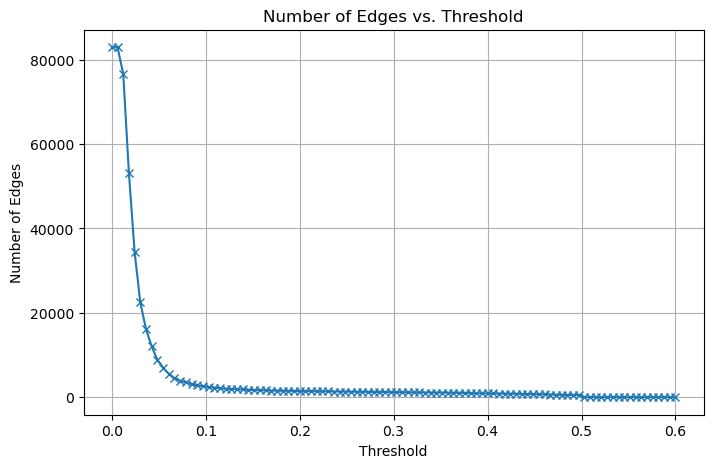

In [59]:
# Range of thresholds to plot
thresholds = np.linspace(0, 0.6, 100)
edge_counts = []

# Calculating the number of edges for each threshold
for threshold in thresholds:
    temp_graph = nx.Graph()
    
    for i, (node1, attr1) in enumerate(nodes):
        tags1 = set(attr1.get('tags', []))
        for j in range(i + 1, len(nodes)):
            node2, attr2 = nodes[j]
            tags2 = set(attr2.get('tags', []))
            
            shared_tags = tags1 & tags2
            weight = len(shared_tags) / (len(tags1) + len(tags2)) if (len(tags1) + len(tags2)) > 0 else 0
            
            if weight > threshold:
                temp_graph.add_edge(node1, node2, weight=weight)
    
    # Store the number of edges for this threshold
    edge_counts.append(temp_graph.number_of_edges())

# Plotting the threshold vs. edge count
plt.figure(figsize=(10, 6))
plt.plot(thresholds, edge_counts, marker='x')
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Number of Edges", fontsize=12)
plt.title("Number of Edges vs. Threshold", fontsize=14)
plt.grid(True)
plt.show()


**Figure 1: Number of edges per Threshold.** The plot shows how the number of edges in the network changes based on a chosen threshold. Whilst the number of edges declines rapidly with small thresholds [0.0, 0.06], the number of edges is more stable (around 700) after a threshold of approximately 0.06. This plot was used to choose a threshold of 0.03, to make the network more sparse without loosing too many connections between videos. 

### Plotting the degree distribution including the average degree:

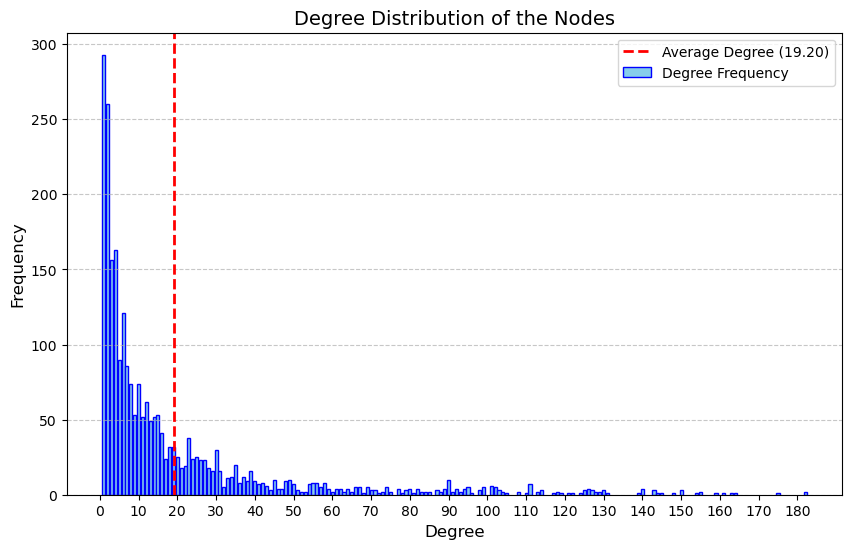

In [31]:
# Calculating the degree distribution and the average degree
degree_sequence = [G.degree(n) for n in G.nodes]
degree_count = {deg: degree_sequence.count(deg) for deg in set(degree_sequence)}
degrees, counts = zip(*sorted(degree_count.items()))
average_degree = sum(degree_sequence) / len(degree_sequence)

# Plotting the degree distribution
plt.figure(figsize=(10, 6))
plt.bar(degrees, counts, width=0.8, color='skyblue', edgecolor='blue', label='Degree Frequency')
plt.axvline(x=average_degree, color='red', linestyle='--', linewidth=2, label=f'Average Degree ({average_degree:.2f})')
plt.title("Degree Distribution of the Nodes", fontsize=14)
plt.xlabel("Degree", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
max_degree = max(degrees)
plt.xticks(np.arange(0, max_degree + 1, 10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()


**Figure 2: Degree distribution of the nodes.** The plot shows the degree distribution of the network. The figure shows an exponentially decreasing degree distribution with an average degree of 19.2. Whilst the majority of nodes have a degree of under 30, some hubs have degrees of up to 182.

## Part 2: Community analysis 

### Determining the structural communities based on the Python Louvain-algorithm and calculating its modularity:

In [57]:
# Using the Louvain algorithm to find communities
louvain_partition = community_louvain.best_partition(G)

# Calculating the modularity
partition_louvain = {}
for node, community in louvain_partition.items():
    if community not in partition_louvain:
        partition_louvain[community] = []
    partition_louvain[community].append(node)
    
partition_list_louvain = [set(nodes) for nodes in partition_louvain.values()]
modularity_value_louvain = nx.algorithms.community.quality.modularity(G, partition_list_louvain)
print(f"Number of Louvain communities detected: {len(partition_louvain)}")
print(f"Louvain modularity: {modularity_value_louvain:.5f}")

# Function to merge the smallest communities
def merge_communities(partition_dict, max_communities):
    while len(partition_dict) > max_communities:
        smallest = sorted(partition_dict.items(), key=lambda x: len(x[1]))[:2]
        (key1, nodes1), (key2, nodes2) = smallest
        merged_nodes = nodes1 + nodes2
        partition_dict[key1] = merged_nodes
        del partition_dict[key2]
    return partition_dict

# Setting a maximum number of communities
max_communities = 30  
partition_louvain = merge_communities(partition_louvain, max_communities)
community_mapping = {old_id: new_id for new_id, old_id in enumerate(partition_louvain.keys(), start=1)}

# Updating node assignments with the new community IDs
final_partition = {}
for community, nodes in partition_louvain.items():
    new_community_id = community_mapping[community]
    for node in nodes:
        final_partition[node] = new_community_id

# Recalculate modularity for the new partition
partition_list_final = [set(nodes) for nodes in partition_louvain.values()]
modularity_value_final = nx.algorithms.community.quality.modularity(G, partition_list_final)
print(f"Number of Louvain communities after merging: {len(partition_louvain)}")
print(f"Louvain modularity after merging: {modularity_value_final:.5f}")

nx.set_node_attributes(G, final_partition, "louvain-community")


Number of Louvain communities detected: 174
Louvain modularity: 0.76274
Number of Louvain communities after merging: 30
Louvain modularity after merging: 0.76155


The Louvain algorithm detected 174 structural communities, with a modularity of 0.763. After limiting the number of structural communities to 30, the modularity decreased to 0.762.

### Determining communities and their modularities based on the country (only taken the first country in the list) and categoryId:

In [58]:
# Community Assignment by `country`
country_partition = {}
for node, data in G.nodes(data=True):
    countries = data.get('country', [])
    primary_country = countries[0] if countries else 'Unknown'  
    data['country_community'] = primary_country
    country_partition[node] = primary_country  

# Community Assignment by `CategoryID`
category_partition = {}
for node, data in G.nodes(data=True):
    category = data.get('categoryId', [])
    data['category_community'] = category
    category_partition[node] = category  

# Modularity calculations 
country_communities = {c: [] for c in set(country_partition.values())}
for node, community in country_partition.items():
    country_communities[community].append(node)
country_modularity = modularity(G, country_communities.values())
print(f"Modularity for Country communities: {country_modularity:.4f}")

category_communities = {c: [] for c in set(category_partition.values())}
for node, community in category_partition.items():
    category_communities[community].append(node)
category_modularity = modularity(G, category_communities.values())
print(f"Modularity for Category communities: {category_modularity:.4f}")


Modularity for Country communities: 0.2692
Modularity for Category communities: 0.4721


By using the category ID and the countries as structural community measures, the resulting modularities were 0.472 and 0.269, respectively. 

### Comparing the Louvain communities with the category partition by making a confusion matrix D and visualizing it using a heat map:

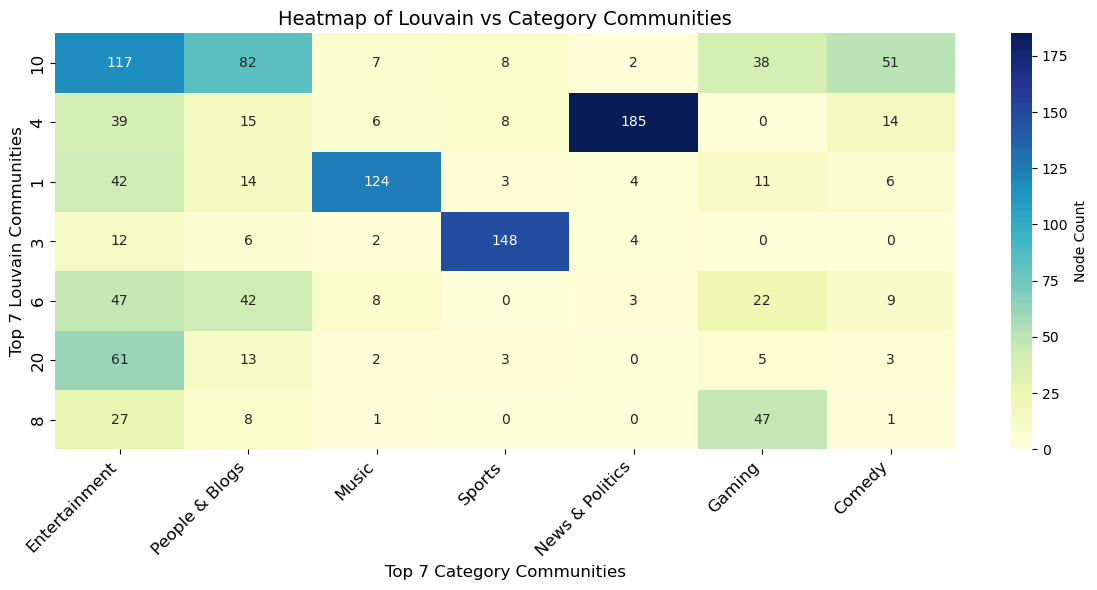

In [38]:
# Category mapping for the category IDs
category_mapping = {
    1: "Film & Animation", 2: "Autos & Vehicles", 10: "Music", 15: "Pets & Animals", 17: "Sports", 18: "Short Movies",
    19: "Travel & Events", 20: "Gaming", 21: "Videoblogging", 22: "People & Blogs", 23: "Comedy", 24: "Entertainment",
    25: "News & Politics", 26: "Howto & Style", 27: "Education", 28: "Science & Technology", 29: "Nonprofits & Activism",
    30: "Movies", 31: "Anime/Animation", 32: "Action/Adventure", 33: "Classics", 34: "Comedy", 35: "Documentary",
    36: "Drama", 37: "Family", 38: "Foreign", 39: "Horror", 40: "Sci-Fi/Fantasy", 41: "Thriller", 42: "Shorts",
    43: "Shows", 44: "Trailers"
}

# Using the top 7 Louvain and Category communities
community_counts = Counter(final_partition.values())
top_louvain_communities = [community for community, _ in community_counts.most_common(7)]
category_counts = Counter(category_partition.values())
top_category_communities = [category for category, _ in category_counts.most_common(7)]

# Initializing the confusion matrix and mapping the communities to the indices
D = np.zeros((7, 7), dtype=int)
louvain_index = {community: idx for idx, community in enumerate(top_louvain_communities)}
category_index = {category: idx for idx, category in enumerate(top_category_communities)}

for node, louvain_community in final_partition.items():
    category_community = category_partition.get(node)
    if louvain_community in top_louvain_communities and category_community in top_category_communities:
        i = louvain_index[louvain_community]
        j = category_index[category_community]
        D[i, j] += 1

# Using the category names for labels
category_labels = [category_mapping.get(int(category), f"Unknown ({category})") for category in top_category_communities]

# Plotting the heatmap
plt.figure(figsize=(12, 6)) 
ax = sns.heatmap(
    D, 
    annot=True, 
    fmt="d", 
    cmap="YlGnBu", 
    xticklabels=category_labels, 
    yticklabels=top_louvain_communities, 
    cbar_kws={'label': 'Node Count'}
)
ax.set_xlabel("Top 7 Category Communities", fontsize=12)
ax.set_ylabel("Top 7 Louvain Communities", fontsize=12)
ax.set_title("Heatmap of Louvain vs Category Communities", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

**Figure 3: Confusion Matrix Heatmap of Category vs Louvain Communities.** The confusion matrix shows that whilst the order of the largest Louvain and category-based communities is not fully aligned, each of the top four Louvain communities aligns well with one of the five largest category-based communities, e.g., Louvain community 1 consists mainly of videos of the "Music" category. This alignment does not hold for all of the top 7 Louvain communities (e.g., for communities 6, 20, or 8), but some similarities are visible. 

### Visualising the node distributions in the communities to see how evenly distributed the nodes are over the communities:

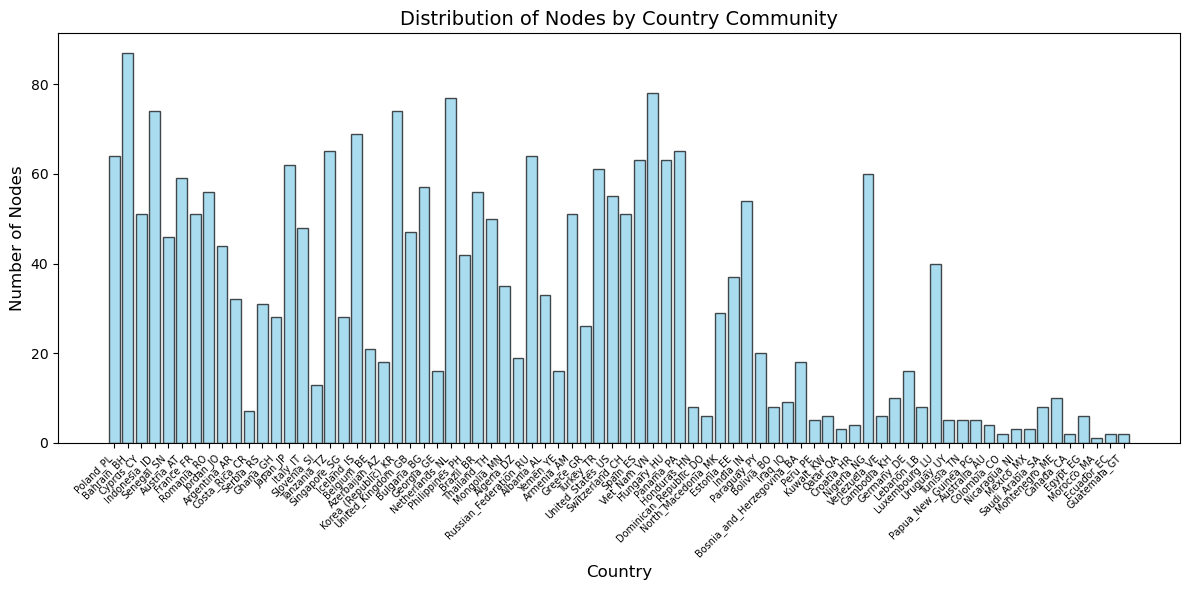

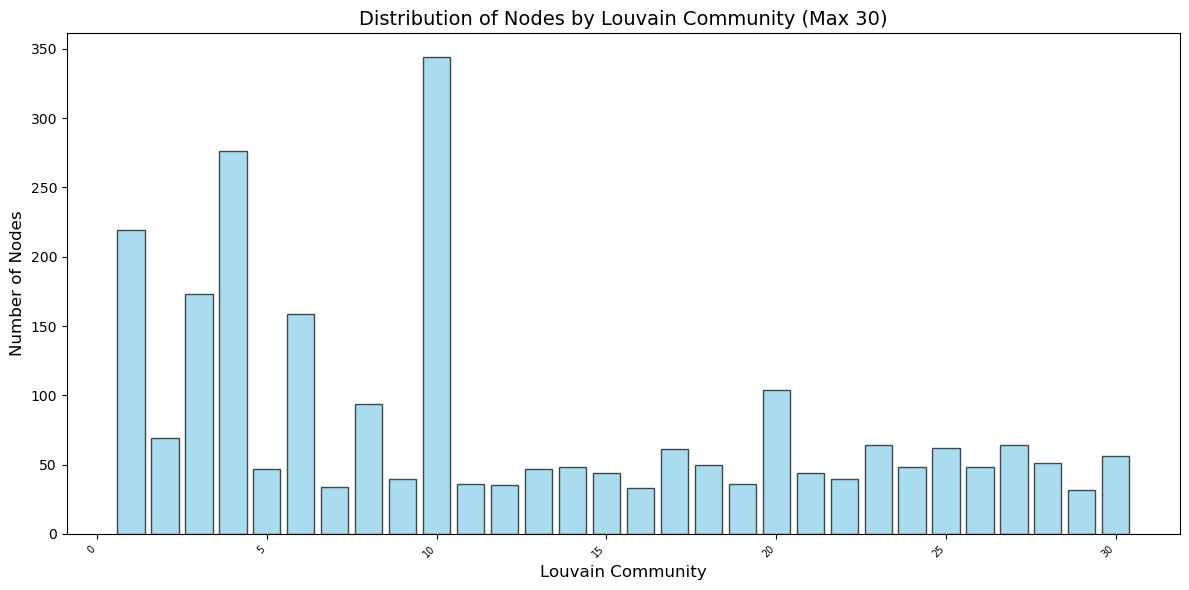

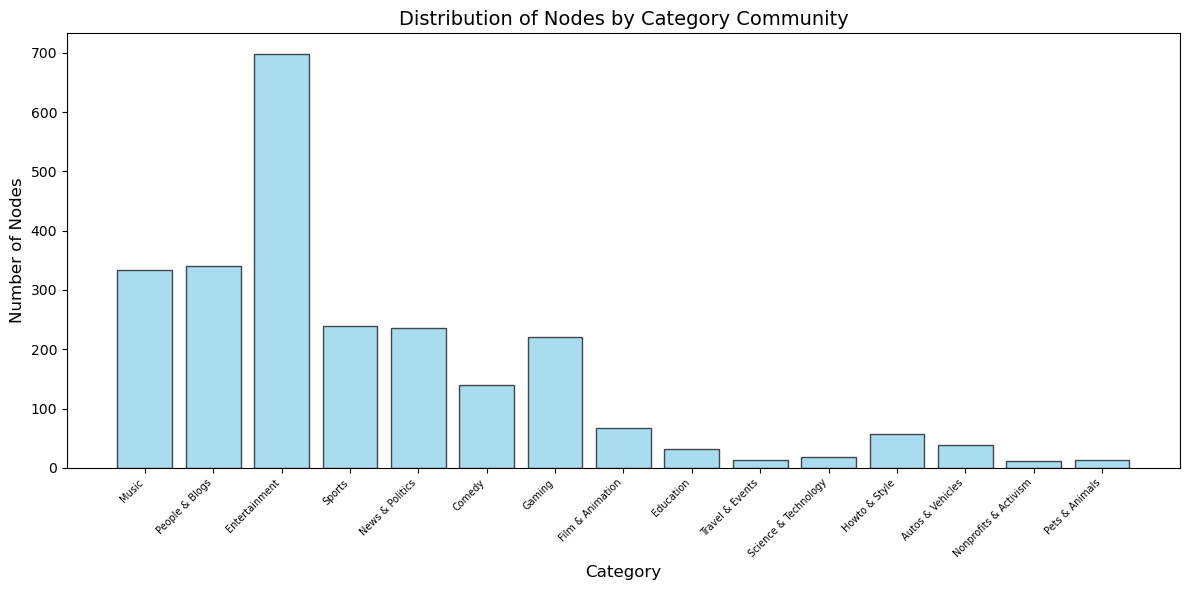

In [42]:
# Function to plot node distributions
def plot_distribution(partition, title, xlabel, mapping=None):
    community_counts = Counter(partition.values())
    communities, counts = zip(*community_counts.items())
    
    if mapping:
        communities = [mapping[int(comm)] if int(comm) in mapping else f"Community {comm}" for comm in communities]
    
    plt.figure(figsize=(12, 6))
    plt.bar(communities, counts, color='skyblue', edgecolor='black', alpha=0.7)
    plt.xticks(rotation=45, ha='right', fontsize=7)  
    plt.yticks(fontsize=10)
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Number of Nodes", fontsize=12)
    plt.tight_layout()
    plt.show()

# Plotting distributions for each community type
plot_distribution(
    country_partition,
    title="Distribution of Nodes by Country Community",
    xlabel="Country"
)
plot_distribution(
    final_partition,  
    title="Distribution of Nodes by Louvain Community (Max 30)",
    xlabel="Louvain Community"
)
plot_distribution(
    category_partition,
    title="Distribution of Nodes by Category Community",
    xlabel="Category",
    mapping=category_mapping
)

**Figure 4: Node distribution per (1) Country,(2) Louvain Community and (3) Category ID.** As observed in the bar graphs there is an apparent disparity in the division of nodes among communities. This provides some insight on the most popular categories, most active country based creators and louvain communities. The country-based node distribution is biased as only the first country in the "country" attribute was used for the community partition.

### Visualizing the network based on the different communities, only visualizing the 20 largest louvain-communities:

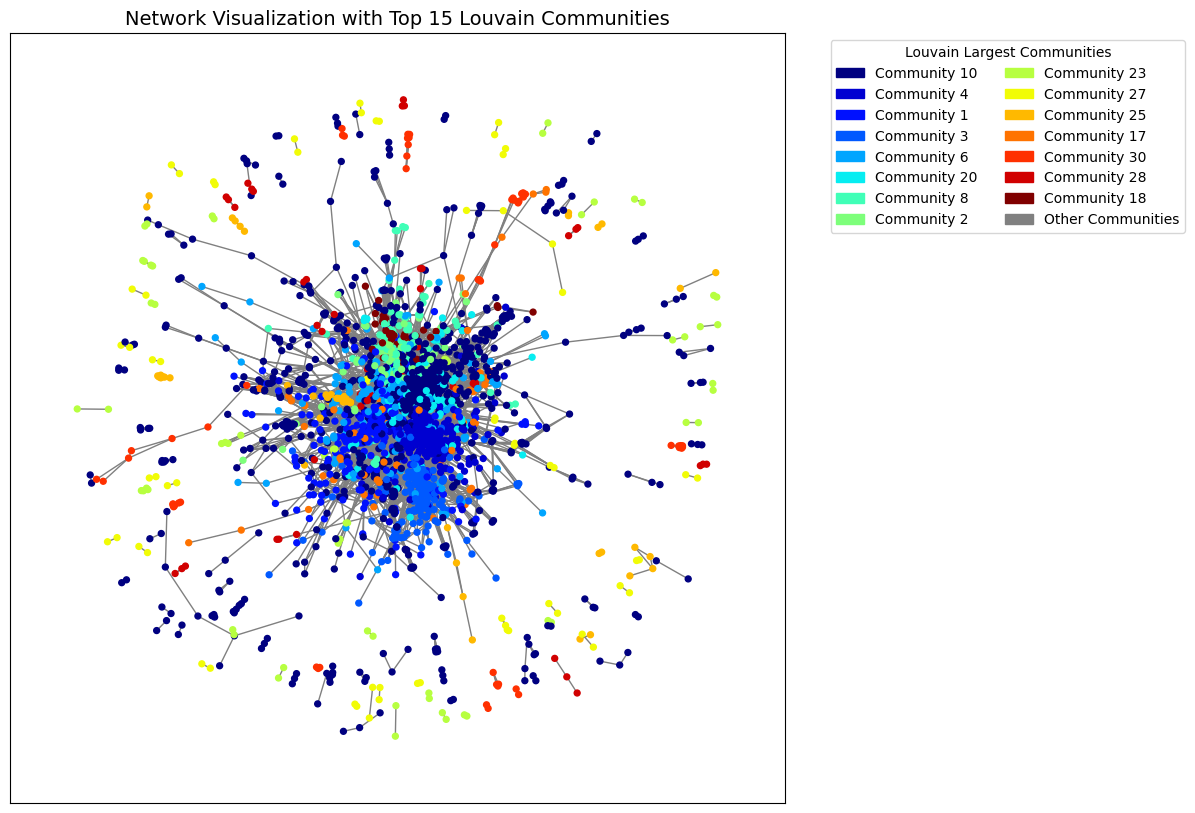

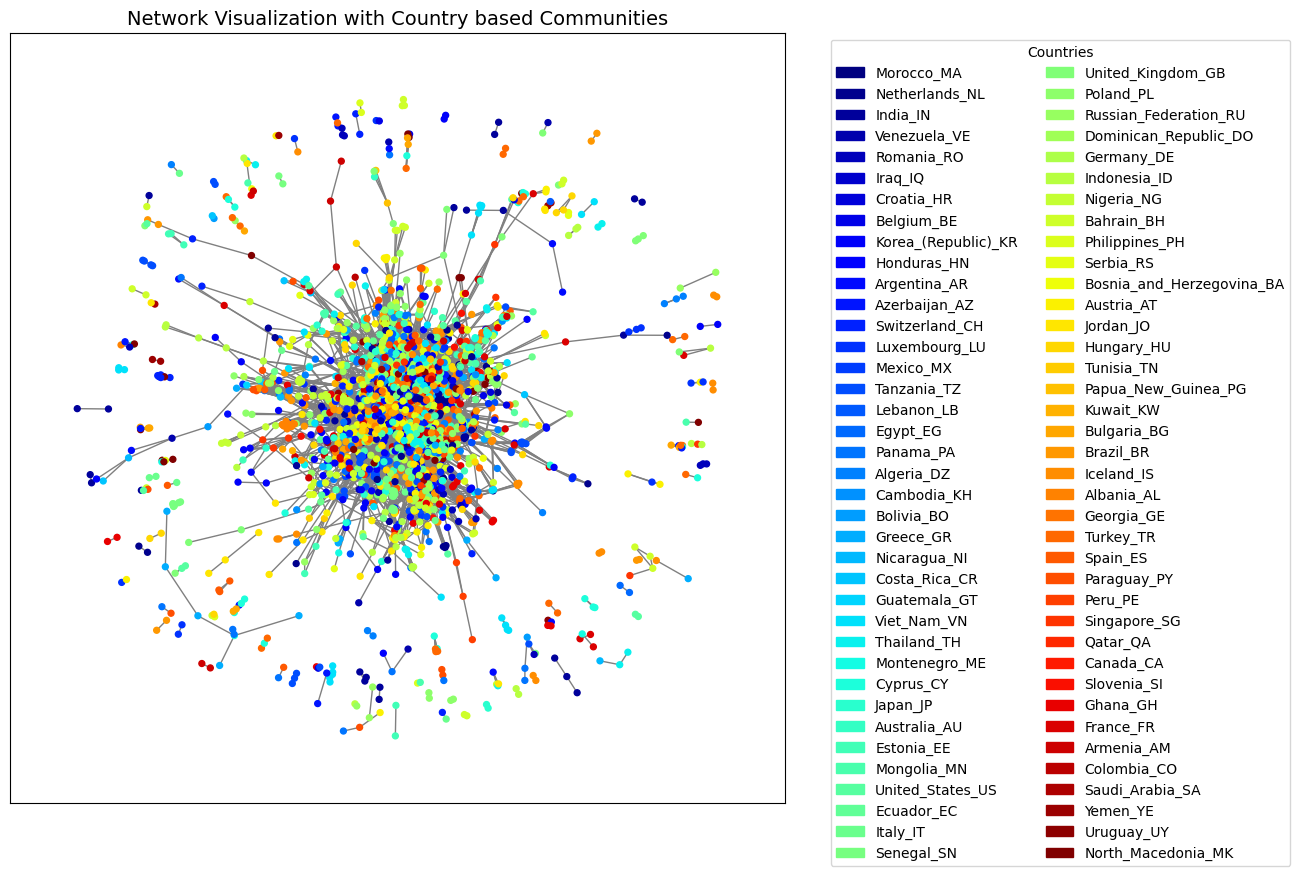

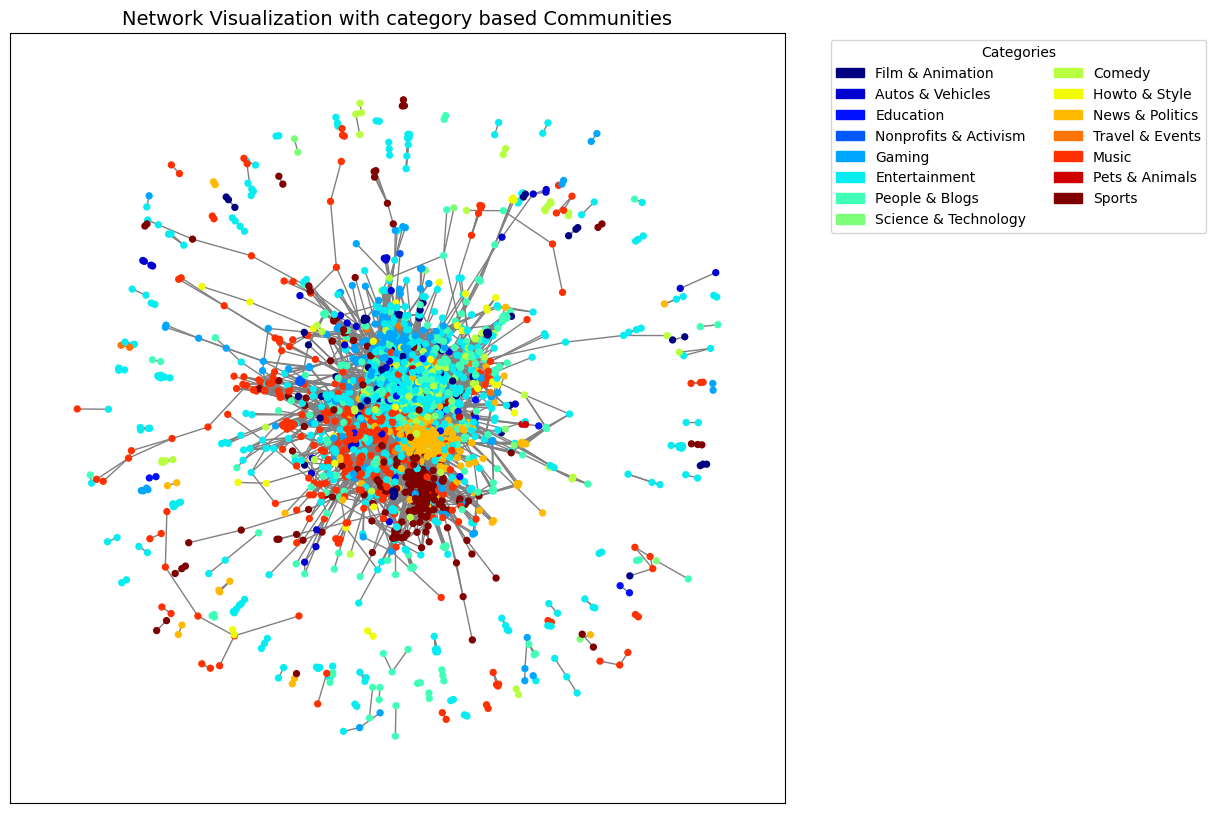

In [46]:
# Function to visualize the network using Force Atlas
def visualize_network_with_communities(G, partition_type, plot_title, legend_title, file_name):
    pos = nx.spring_layout(G, seed=42)
    unique_communities = set(partition_type.values())

    if partition_type == final_partition:
        community_sizes = Counter(partition_type.values())
        
        # Identifying the 15 largest Louvain communities
        largest_communities = [community for community, size in community_sizes.most_common(15)]
        community_color_map = {community: idx for idx, community in enumerate(largest_communities)}
        node_community_values = [
            community_color_map.get(partition_type[node], -1) for node in G.nodes
        ]
        norm = Normalize(vmin=0, vmax=len(largest_communities) - 1) 
    else:
        community_color_map = {community: idx for idx, community in enumerate(unique_communities)}
        node_community_values = [
            community_color_map[partition_type[node]] for node in G.nodes
        ]
        norm = Normalize(vmin=0, vmax=len(unique_communities) - 1) 

    # Drawing the network
    cmap = plt.cm.jet
    plt.figure(figsize=(10, 10))
    nx.draw_networkx(
        G, pos,
        node_color=node_community_values,
        cmap=cmap,
        with_labels=False,
        node_size=18,
        edge_color="gray",
        vmin=0, vmax=norm.vmax
    )

    # Creating the legend
    if partition_type == category_partition:
        category_mapping = {
            1: "Film & Animation", 2: "Autos & Vehicles", 10: "Music", 15: "Pets & Animals", 17: "Sports", 
            18: "Short Movies", 19: "Travel & Events", 20: "Gaming", 21: "Videoblogging", 22: "People & Blogs",
            23: "Comedy", 24: "Entertainment", 25: "News & Politics", 26: "Howto & Style", 27: "Education",
            28: "Science & Technology", 29: "Nonprofits & Activism", 30: "Movies", 31: "Anime/Animation",
            32: "Action/Adventure", 33: "Classics", 34: "Comedy", 35: "Documentary", 36: "Drama", 
            37: "Family", 38: "Foreign", 39: "Horror", 40: "Sci-Fi/Fantasy", 41: "Thriller", 42: "Shorts",
            43: "Shows", 44: "Trailers"
        }

        legend_handles = [
            mpatches.Patch(
                color=cmap(norm(idx)), 
                label=f"{category_mapping.get(int(community), f'Unknown ({community})')}"
            )
            for community, idx in community_color_map.items() if idx != -1
        ]
    elif partition_type == country_partition:
        legend_handles = [
            mpatches.Patch(color=cmap(norm(idx)), label=f"{community}")
            for community, idx in community_color_map.items() if idx != -1
        ]
    elif partition_type == final_partition:
        legend_handles = [
            mpatches.Patch(color=cmap(norm(idx)), label=f"Community {community}")
            for community, idx in community_color_map.items() if idx != -1
        ]
        legend_handles.append(mpatches.Patch(color="grey", label="Other Communities"))

    plt.legend(
        handles=legend_handles,
        title=legend_title,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        ncol=2
    )
    plt.title(plot_title, fontsize=14)
    plt.savefig(file_name, bbox_inches='tight') 
    plt.show()


inputs = [
    {"partition_type": final_partition, "plot_title": "Network Visualization with Top 15 Louvain Communities", "legend_title": "Louvain Largest Communities",  "file_name": "louvain_network"},
    {"partition_type": country_partition, "plot_title": "Network Visualization with Country based Communities", "legend_title": "Countries", "file_name": "country_network"},
    {"partition_type": category_partition, "plot_title": "Network Visualization with category based Communities", "legend_title": "Categories", "file_name": "category_network"}
]

for input_data in inputs:
    visualize_network_with_communities(
        G=G,
        partition_type=input_data["partition_type"],
        plot_title=input_data["plot_title"],
        legend_title=input_data["legend_title"],
        file_name=input_data["file_name"]
    )


**Figure 5: Network visualizations based on (1) Louvain Communities, (2) Country Communities and (3) Category based Communities.** Both the Louvain and CategoryID based communities showcase apparent connected clusters forming which belong to the same community. As for country based communiteis the nodes belonging to a certain country are scattered all over the graph which reinforces the low modularity and weak community structure.

## Part 3: Further network analysis

### Measuring closeness centrality, eigenvector centrality, betweeness centrality and degree centrality

- Closeness Centrality measures how close a node is to all other nodes in the graph.
- Eigenvector Centrality measures the influence of a node based on the importance of its neighbors.
- Betweenness Centrality measures how often a node acts as a bridge along the shortest path between two other nodes.
- Degree Centrality the number of edges connected to a node.


In [47]:
# Initializing the translator for translating the video titles
translator = GoogleTranslator()

# Calculating degree centrality
degree_centrality = nx.degree_centrality(G)
most_central_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)
print("Most central 5 nodes by degree centrality:")
for node in most_central_nodes[:5]:
    title = G.nodes[node].get('title', 'No Title')  
    country = G.nodes[node].get('country', 'No country')
    translated_title = translator.translate(title, source='auto', target='en')
    print(f"Title: {translated_title}, Country: {country}")

# Calculating betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
most_between_central_nodes = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)
print("\nMost central 5 nodes by betweenness centrality:")
for node in most_between_central_nodes[:5]:
    title = G.nodes[node].get('title', 'No Title')  
    country = G.nodes[node].get('country', 'No country')
    translated_title = translator.translate(title, source='auto', target='en')
    print(f"Title: {translated_title}, Country: {country}")

# Calculating eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(G)
most_eigenvector_central_nodes = sorted(eigenvector_centrality, key=eigenvector_centrality.get, reverse=True)
print("\nMost central 5 nodes by eigenvector centrality:")
for node in most_eigenvector_central_nodes[:5]:
    title = G.nodes[node].get('title', 'No Title') 
    country = G.nodes[node].get('country', 'No country')
    translated_title = translator.translate(title, source='auto', target='en')
    print(f"Title: {translated_title}, Country: {country}")

# Calculating closeness centrality
closeness_centrality = nx.closeness_centrality(G)
most_closeness_central_nodes = sorted(closeness_centrality, key=closeness_centrality.get, reverse=True)
print("\nMost central 5 nodes by closeness centrality:")
for node in most_closeness_central_nodes[:5]:
    title = G.nodes[node].get('title', 'No Title') 
    country = G.nodes[node].get('country', 'No country')
    translated_title = translator.translate(title, source='auto', target='en')
    print(f"Title: {translated_title}, Country: {country}")

Most central 5 nodes by degree centrality:
Title: Sharing chopsticks and spoon #shorts, Country: ['Viet_Nam_VN']
Title: Believe everything people say #shorts, Country: ['Viet_Nam_VN']
Title: THE NEW GIRL | Season 2 (FINALE), Episode 9 | Yawaskits, Country: ['Nigeria_NG']
Title: Try not to laugh Game!!!, Country: ['Romania_RO', 'Poland_PL']
Title: The King Copycats Of YouTube, Country: ['Iceland_IS', 'Estonia_EE']

Most central 5 nodes by betweenness centrality:
Title: FIFI - JETA JEM (Magic Song 2024) #musicistheanswer, Country: ['Albania_AL']
Title: I DON'T BELIEVE IT 🤯 TRUMP was elected after having..., Country: ['Italy_IT']
Title: Hiding in Secret Room to Prank My Dad *Security Cameras*, Country: ['Estonia_EE']
Title: I Met Messi, Country: ['Bolivia_BO', 'Colombia_CO', 'Honduras_HN', 'Ecuador_EC', 'Paraguay_PY', 'Guatemala_GT', 'Mexico_MX', 'Dominican_Republic_DO']
Title: Trump will be president again! And now? | #analysis, Country: ['Austria_AT', 'Switzerland_CH', 'Germany_DE', 'Lu

The two most central nodes in degree, eigenvector, and closeness centrality are the same two videos. These nodes likely have the most direct connections through tags within the network and may represent trending or widely shared content. Generally, there are a few videos that occur in the top 5 videos of each of the measures indicating their popularity based on their topics/tags.

### Calculating assortivity based on degrees and categories

Assortativity is a measure of the tendency of nodes in a graph to connect to other nodes that share similar properties, such as degree, attributes, or other nodal characteristics.

In [48]:
# Calculating assortivity based on node degree
degrees = dict(G.degree())
degree_pairs = [(degrees[u], degrees[v]) for u, v in G.edges()]
degree_a, degree_b = zip(*degree_pairs)
assortativity_coefficient, _ = pearsonr(degree_a, degree_b)
print("Assortativity Coefficient based on node degrees:", assortativity_coefficient)

# Calculating assortivity based on category
category_assortativity = nx.attribute_assortativity_coefficient(G, 'categoryId')
print(f"Assortativity coefficient based on 'categoryID': {category_assortativity}")


Assortativity Coefficient based on node degrees: 0.40719483691216946
Assortativity coefficient based on 'categoryID': 0.3390450204085399


The assortativity coefficient of 0.407 indicates a slightly positive correlation for the nodes to connect to others with similar degrees, while the assortativity coefficient of 0.339 shows a weaker tendency for nodes to connect with others sharing the same categoryID.

### Determining the videos that are trending in most countries

In [49]:
# Calculating the number of countries a video is trending in
country_counts = {}
for node, data in G.nodes(data=True):
    if 'country' in data and isinstance(data['country'], list):
        country_counts[node] = len(data['country'])

# Printing the videos which are trending in most countries 
sorted_country_counts = sorted(country_counts.items(), key=lambda item: item[1], reverse=True)
print("Top videos in largest amount of countries:")
for node, count in sorted_country_counts[:10]:
    title = G.nodes[node].get('title', 'No Title') 
    translated_title = translator.translate(title, source='auto', target='en')
    print(f"Video: {translated_title}, Number of countries: {count}")


Top videos in largest amount of countries:
Video: Angel Edgar VS Demon Mortis - Animation, Number of countries: 52
Video: DEMONS ARE ATTACKING BRAWL STARS!!!, Number of countries: 48
Video: BABYMONSTER - 'DRIP' M/V, Number of countries: 45
Video: ROSÉ & Bruno Mars - APT. (Official Music Video), Number of countries: 40
Video: My Daughter's Emotional 15th BIRTHDAY SURPRISE, Number of countries: 33
Video: 진 (Jin) 'I'll Be There' Official MV, Number of countries: 31
Video: HYPERCHARGE FOR WATCHING THE BRAWL STARS WORLD FINALS?! 🥵, Number of countries: 31
Video: HIGHLIGHTS Sporting CP 4-1 Man City | Foden, Gyorkeres hat-trick & Araujo goals, Number of countries: 31
Video: The IMPOSSIBLE Puzzle.., Number of countries: 30
Video: Donald Trump speaks after winning the 2024 Presidential Election, Number of countries: 29


The video which is trending in most countries (52) is "Angel Edgar VS Demon Mortis - Animation". The second and third ranked videos are trending in 48 and 45 videos, respectively. The topics the top 10 videos reach from animations and music videos to sports highlights and political updates which indicates diverse global interests.

## Part 4: Sentiment analysis

### Determining TF-IDF scores for comments across largest Louvain Communities


Top 10 words for Louvain Community 4 based on TF-IDF:
trump: 422.2023
putin: 313.0303
ukrainian: 278.8905
prabowo: 238.3084
harris: 235.2725
ukraine: 228.3391
biden: 221.2037
democrat: 212.7000
sánchez: 198.8853
duterte: 189.4009

Top 10 words for Louvain Community 10 based on TF-IDF:
binod: 2326.4190
lizzie: 207.4730
siowei: 181.4394
feride: 181.4394
hovhannes: 176.8623
tuyet: 156.5758
nobita: 149.6527
nintendo: 145.1325
robleis: 136.0479
deepa: 122.4431

Top 10 words for Louvain Community 1 based on TF-IDF:
아파트: 622.4191
ろ: 224.4790
emily: 170.2686
libratv: 159.8563
miyu: 136.0479
emilia: 135.3417
mirza: 132.6945
miscarriage: 132.5902
jake: 129.5321
jenna: 127.2784

Top 10 words for Louvain Community 3 based on TF-IDF:
zamalek: 354.7546
liverpool: 288.1428
mbappe: 283.2180
marmoush: 282.2994
arsenal: 270.8939
chivas: 238.0838
salah: 229.9588
referee: 222.7331
madrid: 206.5533
ahli: 205.8118

Top 10 words for Louvain Community 6 based on TF-IDF:
kimchi: 343.9224
ㅋㅋㅋ: 292.9316
sherine

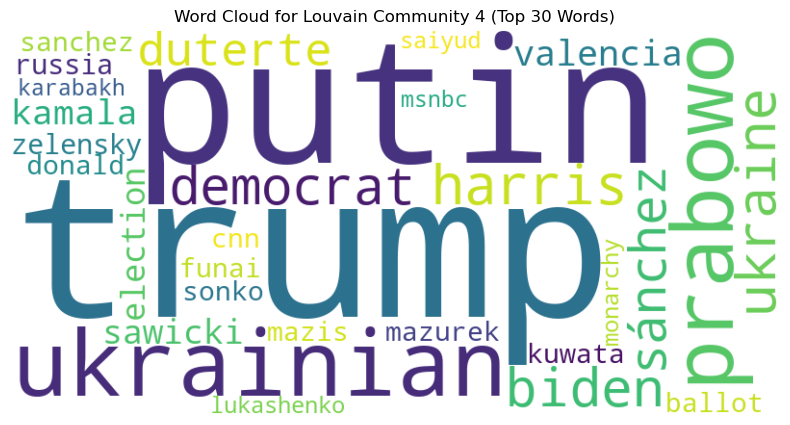

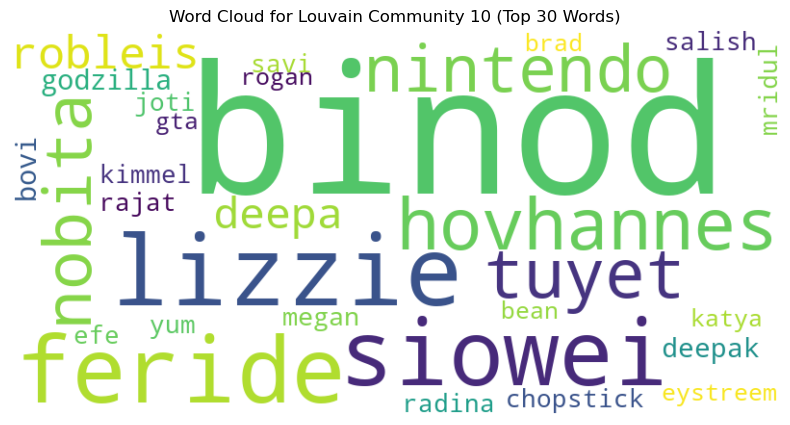

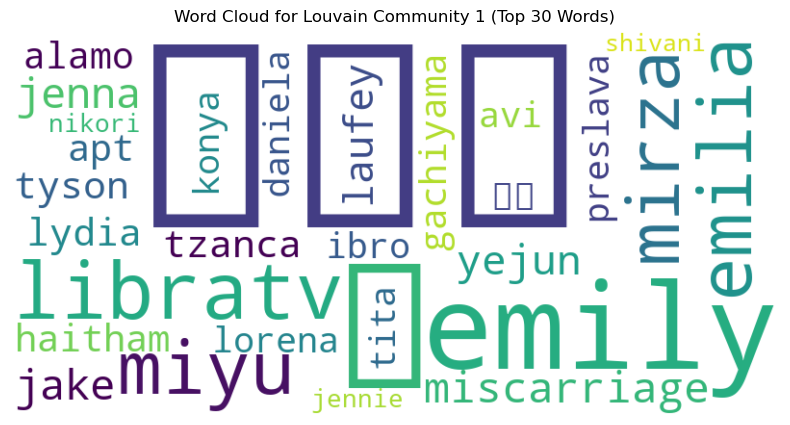

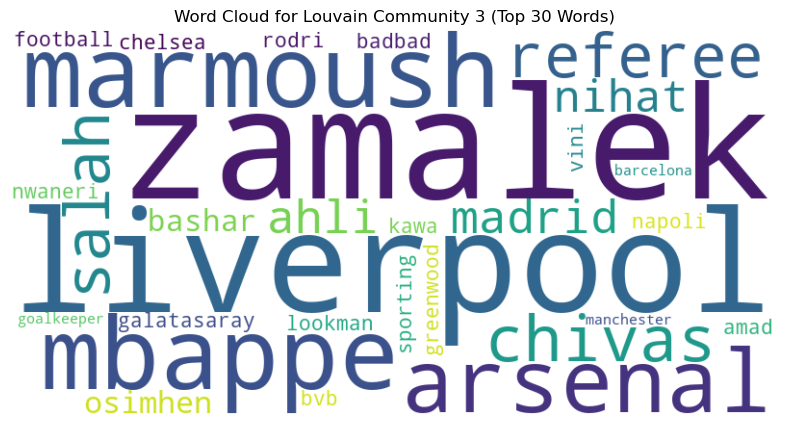

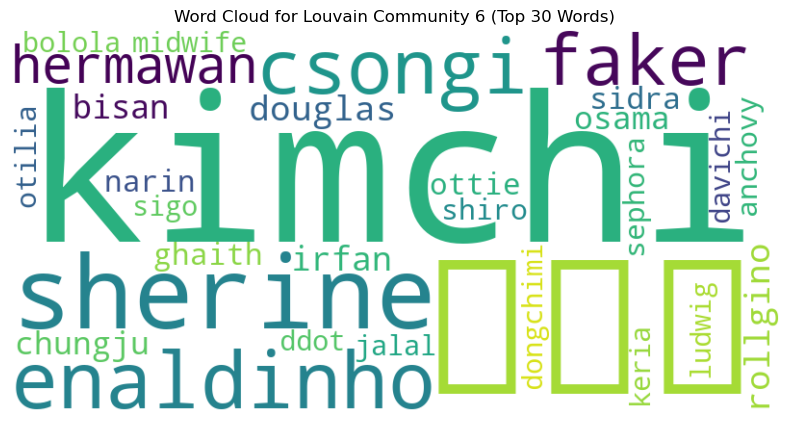

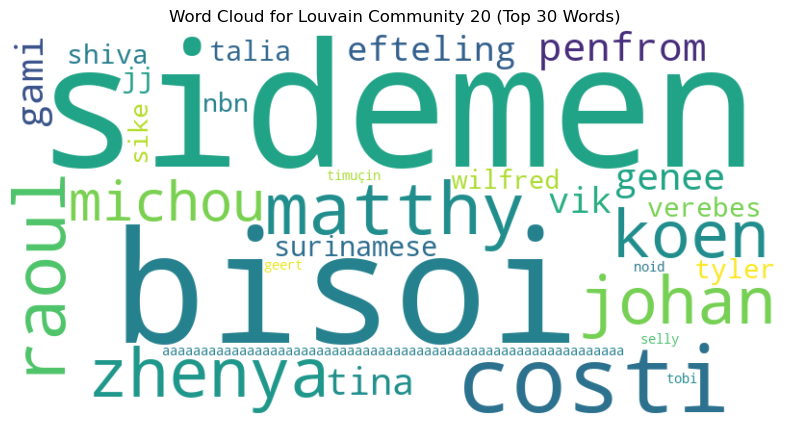

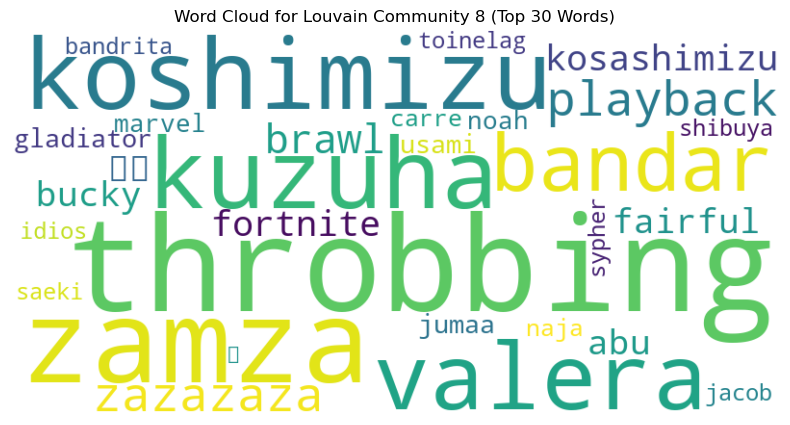

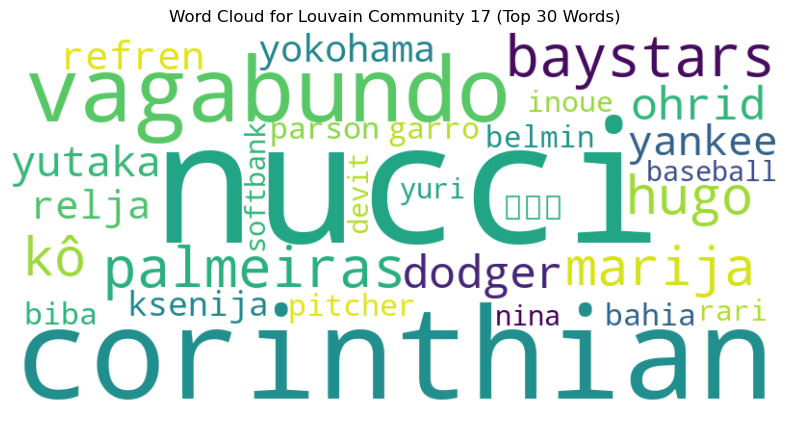

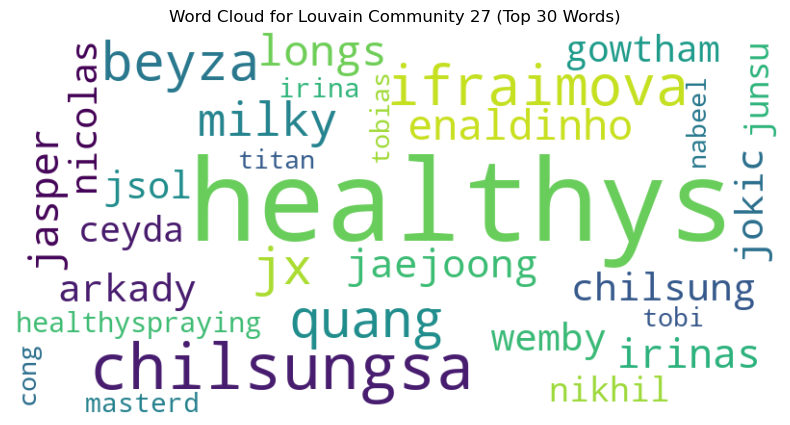

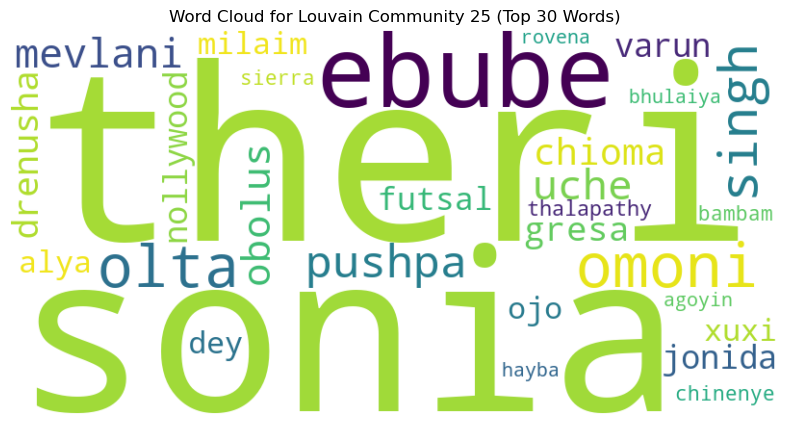

In [50]:
# Initializing lemmatizer 
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to process the text
def process_text(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalpha()]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return [token for token in tokens if token not in stop_words]

# Function to aggregate comments by communities
def aggregate_comments_by_community(graph, partition):
    community_comments = defaultdict(list)
    for node, community in partition.items():
        comments = graph.nodes[node].get('comments', '')
        if comments:
            community_comments[community].extend(process_text(comments))
    return community_comments

# Calculating TF-IDF for each Louvain community
community_comments = aggregate_comments_by_community(G, final_partition)
community_term_frequencies = {community: Counter(tokens) for community, tokens in community_comments.items()}
document_frequency = Counter(word for term_freqs in community_term_frequencies.values() for word in term_freqs)
N = len(community_term_frequencies)
idf_values = {word: math.log(N / df) for word, df in document_frequency.items()}

community_tfidf_scores = {
    community: {word: tf * idf_values[word] for word, tf in term_freqs.items()}
    for community, term_freqs in community_term_frequencies.items()
}

# Identifying the 10 largest Louvain communities
largest_communities = sorted(
    community_comments.keys(), 
    key=lambda community: len(community_comments[community]), 
    reverse=True
)[:10]

# Printing the top 10 words by TF-IDF
for community in largest_communities:
    top_words = sorted(community_tfidf_scores[community].items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"\nTop 10 words for Louvain Community {community} based on TF-IDF:")
    for word, score in top_words:
        print(f"{word}: {score:.4f}")

# Generating word clouds with top 30 words
def generate_wordclouds(community_tfidf_scores, largest_communities, output_folder, top_n=30):
    os.makedirs(output_folder, exist_ok=True)
    for community in largest_communities:
        scores = community_tfidf_scores[community]
        if scores:
            top_words = dict(sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n])
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words)
            wordcloud.to_file(os.path.join(output_folder, f"community_{community}_wordcloud.png"))
            
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.title(f"Word Cloud for Louvain Community {community} (Top {top_n} Words)")
            plt.show()

generate_wordclouds(community_tfidf_scores, largest_communities, 'tfidf_wordclouds_Louvain', top_n=30)


We can observe the top 10 words across the largest Louvain Communities according to the TF-IDF scores and their visualizations usig wordclouds. Each Louvain Community has a set of top words that more or less belong to a particular theme or topic. For eg: words for Community 4 indicate the theme to be politics while for Community 3 it is football (Premier League).

### Determining TF-IDF scores for comments across Countries

In [51]:
# Function to aggregate comments by countries
def aggregate_comments_by_country(graph):
    """Aggregate comments for each country from node attributes."""
    country_comments = defaultdict(list)
    for node, data in graph.nodes(data=True):
        countries = data.get('country', []) 
        comments = data.get('comments', '')
        if comments:
            for country in countries:  
                country_comments[country].extend(process_text(comments))
    return country_comments

# Calculating TF-IDF for each country
country_comments = aggregate_comments_by_country(G)
country_term_frequencies = {country: Counter(tokens) for country, tokens in country_comments.items()}
country_document_frequency = Counter(word for term_freqs in country_term_frequencies.values() for word in term_freqs)
N = len(country_term_frequencies)
idf_values = {word: math.log(N / df) for word, df in country_document_frequency.items()}

country_tfidf_scores = {
    country: {word: tf * idf_values[word] for word, tf in term_freqs.items()}
    for country, term_freqs in country_term_frequencies.items()
}

# Printing the top 10 words by TF-IDF
top_words_by_country_tfidf = {
    country: sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]
    for country, scores in country_tfidf_scores.items()
}

for country, top_words in top_words_by_country_tfidf.items():
    print(f"\nTop 10 words for Country: {country} based on TF-IDF:")
    for word, score in top_words:
        print(f"{word}: {score:.4f}")


Top 10 words for Country: Poland_PL based on TF-IDF:
sawicki: 205.9553
genzie: 205.9553
polish: 205.8793
shalt: 197.0049
douglas: 195.5106
przemek: 184.0451
poland: 173.4546
tusk: 170.7375
mazurek: 166.5170
warsaw: 158.6218

Top 10 words for Country: Bahrain_BH based on TF-IDF:
israa: 222.6389
abu: 199.6514
sherine: 179.1155
singh: 158.0063
allah: 157.6235
sesame: 122.3157
bashar: 118.8523
bandar: 110.4824
omar: 103.9324
ghaith: 82.0248

Top 10 words for Country: Jordan_JO based on TF-IDF:
gigi: 408.7311
rania: 382.2291
israa: 222.6389
sherine: 154.0058
ahli: 115.7243
zamalek: 94.1203
abu: 85.7293
yahya: 79.7781
adel: 77.4407
allah: 74.2356

Top 10 words for Country: Yemen_YE based on TF-IDF:
israa: 222.6389
sherine: 195.8552
allah: 121.6922
abu: 119.1004
bashar: 113.8304
bandar: 108.8085
marmoush: 93.2496
ghaith: 83.6988
sesame: 83.5327
nour: 78.7500

Top 10 words for Country: Algeria_DZ based on TF-IDF:
rania: 276.3102
gigi: 265.8736
algerian: 136.4254
sherine: 103.7865
algeria: 98.

Here, we list the top words for each country according to TF-IDF scores. There are no clear patterns/trends visible, thus aligning with our observtion that Country is not a good community division for the videos. Most of the top words are just names and there are only a few relevant words for some countries like India and Japan.

### Determining TF-IDF scores for comments across Categories


Top 10 words for Category: Entertainment (ID: 24) based on TF-IDF:
ruhi: 372.7571
salish: 360.6676
abhira: 333.0902
leyla: 328.4292
nidal: 287.0533
fede: 252.6808
nur: 239.8062
jordanmatter: 216.6440
movie: 214.9375
chilsungsa: 211.2279

Top 10 words for Category: News & Politics (ID: 25) based on TF-IDF:
trump: 303.9215
duterte: 193.4307
sonko: 149.3584
akua: 143.5267
prabowo: 136.8022
monarchy: 134.9985
sawicki: 127.2784
sanchez: 120.2798
democrat: 117.5498
donkor: 113.7381

Top 10 words for Category: People & Blogs (ID: 22) based on TF-IDF:
asbel: 1161.7535
slime: 388.5073
israa: 296.1907
ろ: 178.7313
emily: 158.6107
copito: 151.6508
hovhannes: 140.8186
zhenya: 126.9389
emilia: 120.2798
clik: 119.1542

Top 10 words for Category: Music (ID: 10) based on TF-IDF:
healthys: 1825.2258
nucci: 335.7982
song: 329.0960
아파트: 245.8182
album: 200.5262
arashi: 184.1474
bake: 175.7780
lyric: 172.6591
ifraimova: 157.0669
amadeus: 151.6508

Top 10 words for Category: Sports (ID: 17) based on TF-IDF

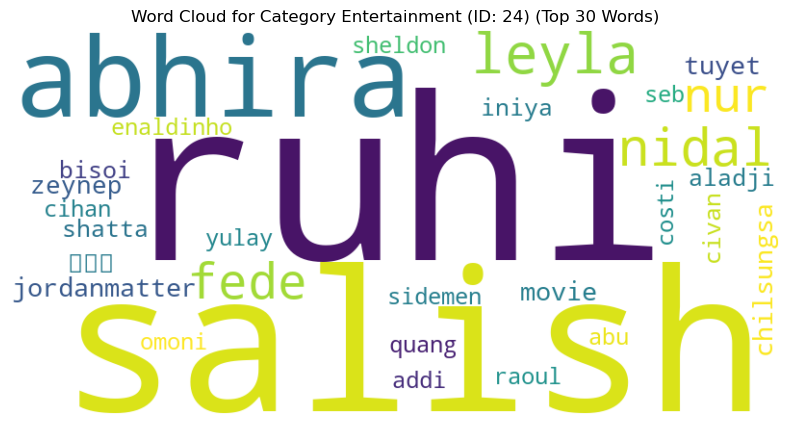

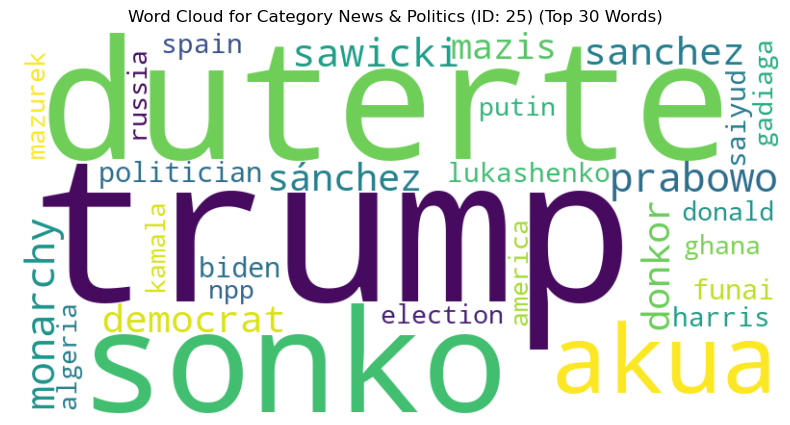

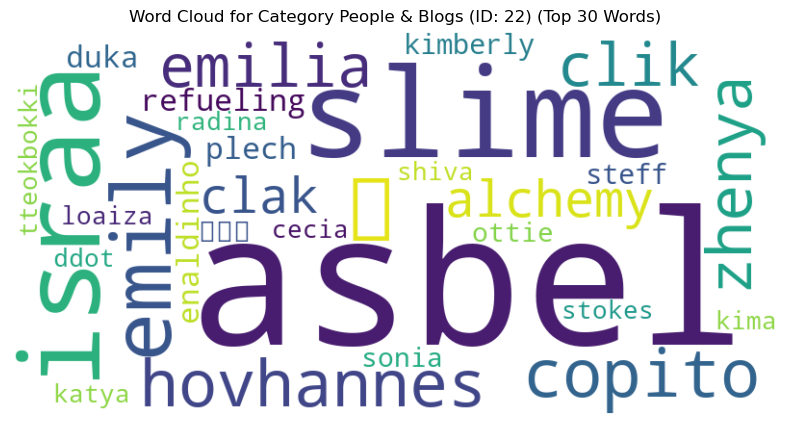

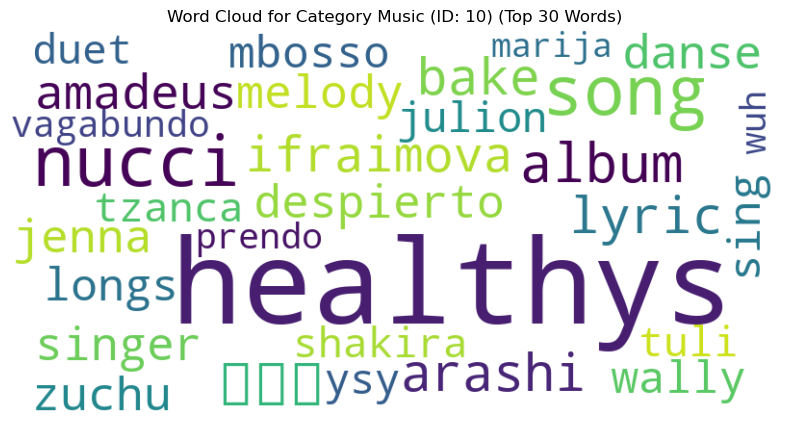

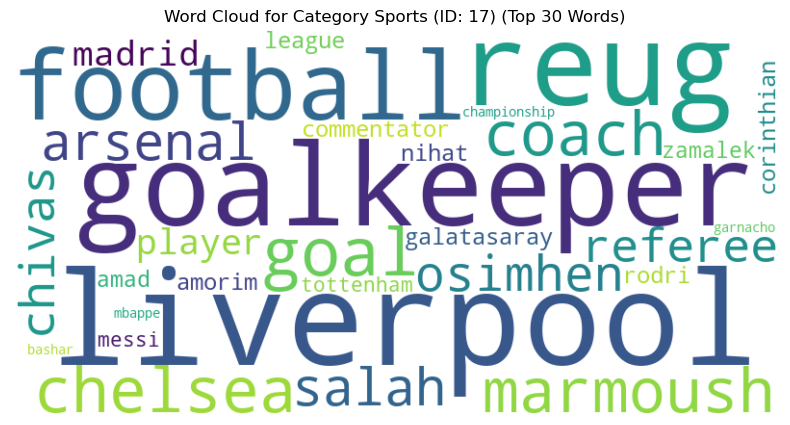

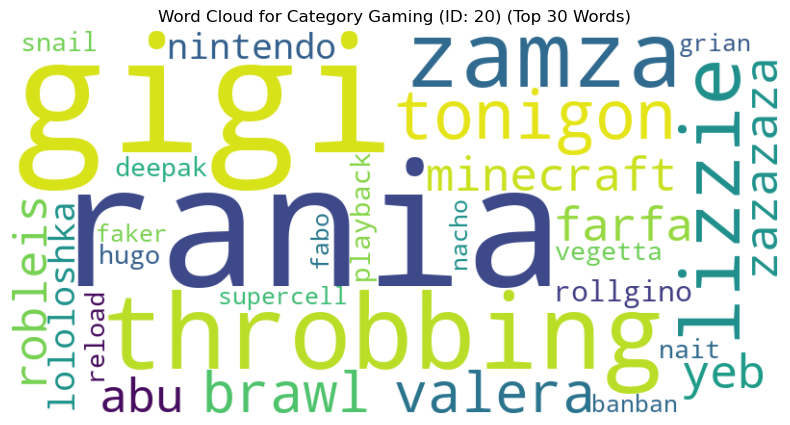

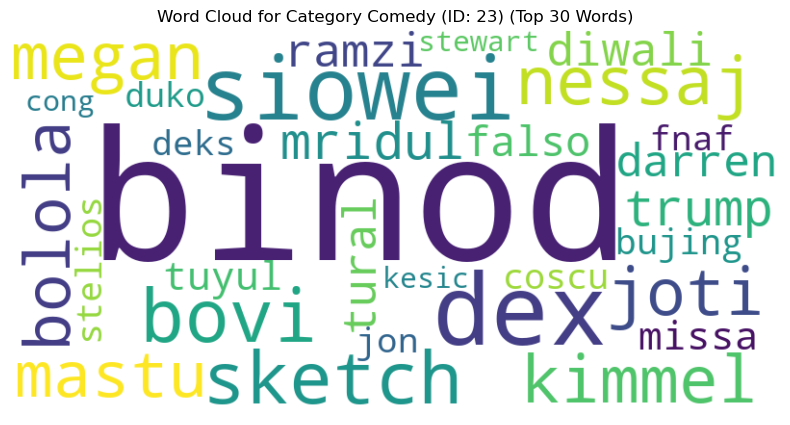

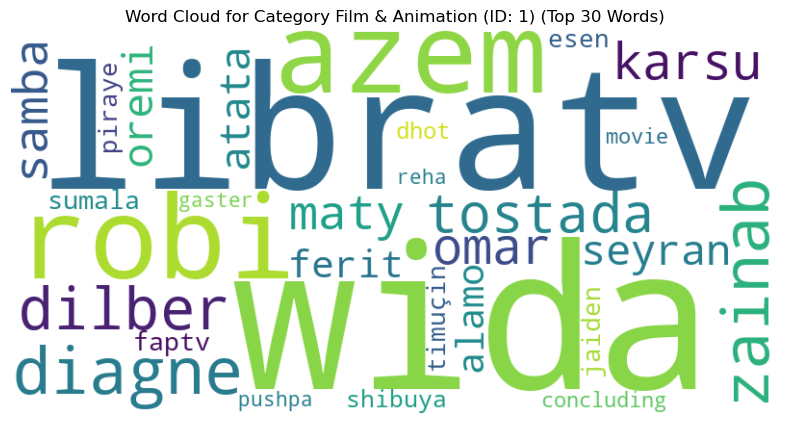

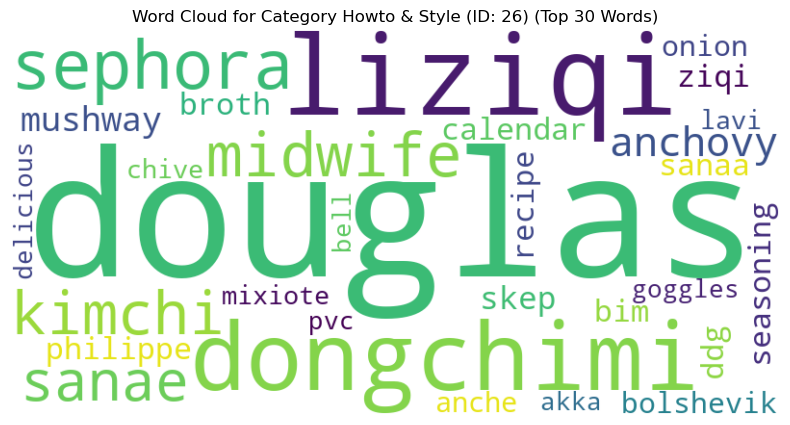

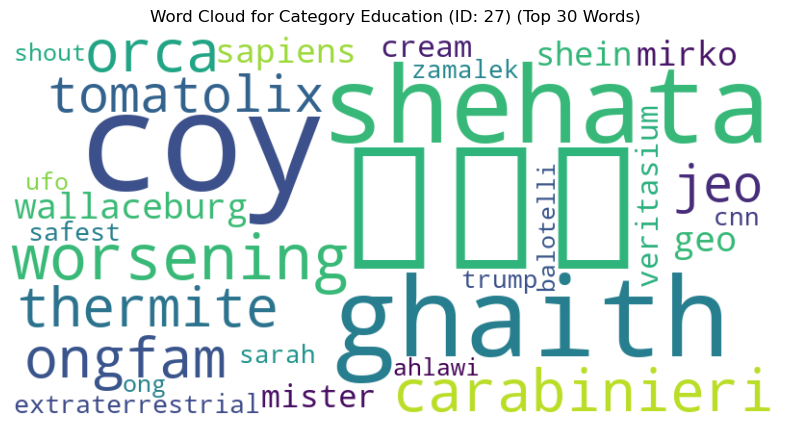

In [52]:
# Function to aggregate comments by categoryID
def aggregate_comments_by_category(graph):
    """Aggregate comments for each category ID from node attributes."""
    category_comments = defaultdict(list)
    for node, data in graph.nodes(data=True):
        category_id = data.get('categoryId')  
        comments = data.get('comments', '')
        if category_id and comments:
            category_comments[category_id].extend(process_text(comments))
    return category_comments

# Calculating TF-IDF for each category
category_comments = aggregate_comments_by_category(G)
category_term_frequencies = {category: Counter(tokens) for category, tokens in category_comments.items()}
category_document_frequency = Counter(word for term_freqs in category_term_frequencies.values() for word in term_freqs)
N = len(category_term_frequencies)
idf_values = {word: math.log(N / df) for word, df in category_document_frequency.items()}

# Calculate TF-IDF scores for each category
category_tfidf_scores = {
    category: {word: tf * idf_values[word] for word, tf in term_freqs.items()}
    for category, term_freqs in category_term_frequencies.items()
}

# Identify the 10 largest categories by number of comments
largest_categories = sorted(
    category_comments.keys(),
    key=lambda category: len(category_comments[category]),
    reverse=True
)[:10]

# Printing the top 10 words by TF-IDF
top_words_by_category_tfidf = {
    category: sorted(category_tfidf_scores[category].items(), key=lambda x: x[1], reverse=True)[:10]
    for category in largest_categories
}

for category, top_words in top_words_by_category_tfidf.items():
    category_name = category_mapping.get(int(category), f"Unknown Category ({category})")
    print(f"\nTop 10 words for Category: {category_name} (ID: {category}) based on TF-IDF:")
    for word, score in top_words:
        print(f"{word}: {score:.4f}")

# Generating word clouds with top 30 words
def generate_category_wordclouds(category_tfidf_scores, largest_categories, output_folder, top_n=30):
    os.makedirs(output_folder, exist_ok=True)
    for category in largest_categories:
        scores = category_tfidf_scores[category]
        if scores:
            top_words = dict(sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n])
            category_name = category_mapping.get(int(category), f"Unknown Category ({category})")
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words)
            wordcloud.to_file(os.path.join(output_folder, f"category_{category}_wordcloud.png"))
            
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.title(f"Word Cloud for Category {category_name} (ID: {category}) (Top {top_n} Words)")
            plt.show()

generate_category_wordclouds(category_tfidf_scores, largest_categories, 'tfidf_wordclouds_Category', top_n=30)


We have listed the top 10 words for each category based on TF-IDF and visualized the wordclouds. We can observe that these top words strongly correspond to the Category themes. For eg, News & Politcs has 'trump', 'duterte' , 'sonko' etc while Sports has 'liverpool', 'reug' and other relevant words.

### Loading the LabMT word list and emoji sentiment scores for the sentiment analysis

In [ ]:
# Sampling the sentiment score files
a = pd.read_csv('emoji_sentiment.csv')
b = pd.read_csv('labMIT.csv')

new_rows = pd.DataFrame()
new_rows['word'] = a.iloc[:, 0]  

# Normalizing the scores to a 0-10 scale 
new_rows['happiness_average'] = 5 * (a.iloc[:, 8] + 1) 

# Storing new dataframe with combined scores
b = pd.concat([b, new_rows], ignore_index=True)
b.to_csv('labMITemoji.csv', index=False)


In [59]:
# Function to load the sentimen scores create a dictionary
def load_labmt_word_list(csv_file_path):
    labmt_words = {}

    with open(csv_file_path, mode='r', encoding='utf-8') as csv_file:
        csv_reader = csv.DictReader(csv_file) 
        for row in csv_reader:
            word = row['word'].lower()  
            happiness_score = float(row['happiness_average']) if row['happiness_average'].strip() else 0
            labmt_words[word] = happiness_score  
    
    return labmt_words

csv_file_path = 'labMITemoji.csv' 
labmt_words_dict = load_labmt_word_list(csv_file_path)
print("LabMT and emoji sentiment scores loaded.")

LabMT and emoji sentiment scores loaded.


The LabMT data was combined with an emoji sentiment list to evaluate the sentiment of comments and transcripts.

### Sentiment analysis for all video comments and transcripts:

In [60]:
# Function to calculate the sentiment score
def calculate_sentiment(tokens, labmt_words):
    sentiment_score = 0
    count = 0
    for token in tokens:
        if token in labmt_words:
            sentiment_score += labmt_words[token]
            count += 1
    return sentiment_score / count if count > 0 else 0

# Function to tokenize text
def process_text(text):
    pattern = r'[\w\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF]+'
    matches = re.findall(pattern, text)
    return matches

# Adding sentiment scores as node properties
for node, data in G.nodes(data=True):
    comments = data.get('comments', '')
    transcript = data.get('transcript', '')
    comment_tokens = process_text(comments)
    transcript_tokens = process_text(transcript)
    comment_sentiment = calculate_sentiment(comment_tokens, labmt_words_dict)
    transcript_sentiment = calculate_sentiment(transcript_tokens, labmt_words_dict)
    
    sentiment_comparison = {
        'comments_sentiment': comment_sentiment,
        'transcript_sentiment': transcript_sentiment,
        'difference': abs(comment_sentiment - transcript_sentiment)
    }
    
    G.nodes[node]['sentiment_comparison'] = sentiment_comparison


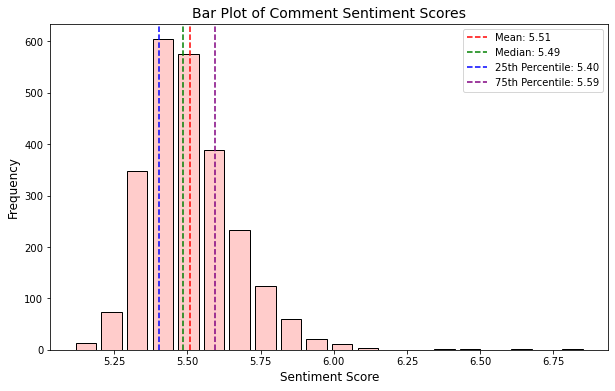

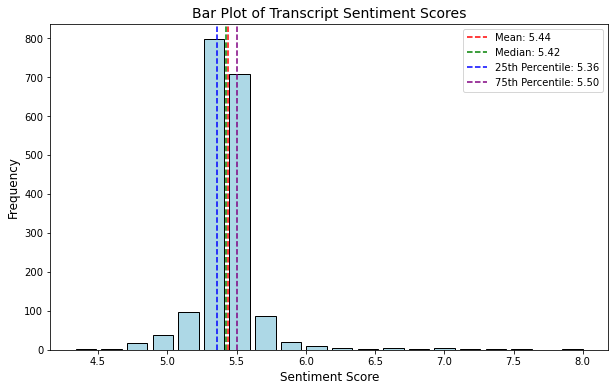


Top 10 Saddest Comments
-----------------------
Title: The most sharp stone in the world #thuthach
    Sentiment: 5.11
    Country: ['Viet_Nam_VN']

Title: The one who gets angry loses all against all 😱 |The House of the Cuernudos (Chapter 21)
    Sentiment: 5.15
    Country: ['Panama_PA', 'Argentina_AR', 'Costa_Rica_CR', 'Bolivia_BO', 'Colombia_CO', 'Honduras_HN', 'Ecuador_EC', 'Paraguay_PY', 'Nicaragua_NI', 'Guatemala_GT', 'Peru_PE', 'Mexico_MX', 'Chile_CL']

Title: Motorbike Smashes Into Porsche! 😱
    Sentiment: 5.15
    Country: ['Netherlands_NL', 'Spain_ES', 'Hungary_HU', 'Romania_RO', 'Armenia_AM', 'Switzerland_CH', 'Bulgaria_BG', 'Mongolia_MN', 'North_Macedonia_MK', 'Cyprus_CY', 'Belgium_BE', 'Serbia_RS', 'Poland_PL', 'Luxembourg_LU', 'Azerbaijan_AZ', 'Slovenia_SI', 'Bosnia_and_Herzegovina_BA', 'Italy_IT', 'Estonia_EE', 'Croatia_HR', 'Georgia_GE', 'Albania_AL', 'Greece_GR', 'Montenegro_ME']

Title: We challenge 720s with a 1800HP trackhawk
    Sentiment: 5.16
    Country: ['Pa

In [61]:
# Function to extract sentiment values for comments and transcripts
def extract_sentiments(graph, sentiment_type):
    return [
        data['sentiment_comparison'][sentiment_type]
        for _, data in graph.nodes(data=True)
        if data.get('sentiment_comparison', {}).get(sentiment_type) not in (None, 0)
    ]

comment_sentiments = extract_sentiments(G, 'comments_sentiment')
transcript_sentiments = extract_sentiments(G, 'transcript_sentiment')

# Function to calculate statistics and plot sentiment distribution
def plot_sentiment_distribution(sentiments, title, color, name, xlabel='Sentiment Score', ylabel='Frequency'):
    mean_sentiment = np.mean(sentiments)
    median_sentiment = np.median(sentiments)
    percentile_25 = np.percentile(sentiments, 25)
    percentile_75 = np.percentile(sentiments, 75)
    
    num_bins = 20
    frequencies, bin_edges = np.histogram(sentiments, bins=num_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, frequencies, width=(bin_edges[1] - bin_edges[0]) * 0.8, color=color, edgecolor='black')
    plt.axvline(mean_sentiment, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_sentiment:.2f}')
    plt.axvline(median_sentiment, color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {median_sentiment:.2f}')
    plt.axvline(percentile_25, color='blue', linestyle='dashed', linewidth=1.5, label=f'25th Percentile: {percentile_25:.2f}')
    plt.axvline(percentile_75, color='purple', linestyle='dashed', linewidth=1.5, label=f'75th Percentile: {percentile_75:.2f}')
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend()
    plt.savefig(name + "_sentiment.png")
    plt.show()

plot_sentiment_distribution(comment_sentiments, title='Bar Plot of Comment Sentiment Scores', color='#ffcccb', name="comment")
plot_sentiment_distribution(transcript_sentiments, title='Bar Plot of Transcript Sentiment Scores', color='#add8e6', name="transcript")

# Function to extract and sort sentiment values for happiest and saddest videos
def extract_and_sort_sentiments(graph, sentiment_type):
    return sorted(
        [
            (node, data['sentiment_comparison'][sentiment_type])
            for node, data in graph.nodes(data=True)
            if data.get('sentiment_comparison', {}).get(sentiment_type) not in (None, 0)
        ],
        key=lambda x: x[1]
    )

comment_sorted = extract_and_sort_sentiments(G, 'comments_sentiment')
transcript_sorted = extract_and_sort_sentiments(G, 'transcript_sentiment')

saddest_comments = comment_sorted[:10]
happiest_comments = comment_sorted[-10:]
saddest_transcripts = transcript_sorted[:10]
happiest_transcripts = transcript_sorted[-10:]

# Function to format and print top happiest/saddest results
def print_top_sentiments(graph, sorted_data, title, translator):
    print(f"\n{title}")
    print("-" * len(title))
    for video, sentiment in sorted_data:
        node_data = graph.nodes[video]
        title = node_data.get('title', 'No Title')
        country = node_data.get('country', 'No Country')
        translated_title = translator.translate(title, src='auto', dest='en').text

        print(f"Title: {translated_title}")
        print(f"    Sentiment: {sentiment:.2f}")
        print(f"    Country: {country}\n")

# Printing top 10 happiest and saddest videos
translator = Translator()
print_top_sentiments(G, saddest_comments, "Top 10 Saddest Comments", translator)
print_top_sentiments(G, happiest_comments, "Top 10 Happiest Comments", translator)
print_top_sentiments(G, saddest_transcripts, "Top 10 Saddest Transcripts", translator)
print_top_sentiments(G, happiest_transcripts, "Top 10 Happiest Transcripts", translator)


**Figure 6: Frequency Distribution of (1) Sentiment Scores for Comments and (2) Sentiment Scores for Transcripts along with their statistics.** The mean of the comments' sentiment scores is slightly higher (5.51) than that of transcripts (5.44) and it can be observed that transcripts show a wider range of sentiments (4.32-8.02) compared to comments (5.11-6.86).

We have also listed the top 10 saddest and happiest comments and transcripts. We can observe that the vides with the lowest sentiment scores are associated with topics like accidents, crime, and "Squid Game 2" while the highest ones are about Halloween or family content.

### Sentiment Analysis for Comments and Transcripts across Louvain Communities

In [62]:
# Function to calculate average sentiments
def calculate_average_sentiments(graph, partition=None, sentiment_key=None, attribute_key=None):
    group_sentiments = defaultdict(list)

    if partition:
        for node, group in partition.items():
            sentiment = graph.nodes[node].get('sentiment_comparison', {}).get(sentiment_key)
            if group and sentiment not in (None, 0):
                group_sentiments[group].append(sentiment)
    elif attribute_key:
        for node, data in graph.nodes(data=True):
            group = data.get(attribute_key)
            sentiment = data.get('sentiment_comparison', {}).get(sentiment_key)
            if group and sentiment not in (None, 0):
                group_sentiments[group].append(sentiment)
    
    return {group: np.mean(sentiments) for group, sentiments in group_sentiments.items() if sentiments}

# Function to display the happiest and saddest groups
def display_top_groups(title, group_sentiments, mapping=None, top_n=3, group_type="Community"):
    sorted_groups = sorted(group_sentiments.items(), key=lambda x: x[1], reverse=True)
    happiest_groups = sorted_groups[:top_n]
    saddest_groups = sorted_groups[-top_n:]

    print(f"\n{title}")
    print("-" * len(title))

    print("\nHappiest Groups:")
    for group_id, avg_sent in happiest_groups:
        group_name = (
            f"Category {mapping.get(int(group_id), f'Unknown ({group_id})')}"
            if group_type == "Category"
            else f"{group_type} {group_id}"
        )
        print(f"{group_name}: Average Sentiment = {avg_sent:.2f}")

    print("\nSaddest Groups:")
    for group_id, avg_sent in saddest_groups:
        group_name = (
            f"Category {mapping.get(int(group_id), f'Unknown ({group_id})')}"
            if group_type == "Category"
            else f"{group_type} {group_id}"
        )
        print(f"{group_name}: Average Sentiment = {avg_sent:.2f}")

# Calculating average sentiments for the Louvain communities
community_sentiments_comments = calculate_average_sentiments(G, partition=final_partition, sentiment_key='comments_sentiment')
community_sentiments_transcripts = calculate_average_sentiments(G, partition=final_partition, sentiment_key='transcript_sentiment')

# Display happiest and saddest communities
display_top_groups(
    "Community Sentiment Analysis for Comments",
    community_sentiments_comments,
    group_type="Community"
)
display_top_groups(
    "Community Sentiment Analysis for Transcripts",
    community_sentiments_transcripts,
    group_type="Community"
)



Community Sentiment Analysis for Comments
-----------------------------------------

Happiest Groups:
Community 9: Average Sentiment = 5.63
Community 1: Average Sentiment = 5.62
Community 14: Average Sentiment = 5.59

Saddest Groups:
Community 3: Average Sentiment = 5.46
Community 15: Average Sentiment = 5.42
Community 4: Average Sentiment = 5.39

Community Sentiment Analysis for Transcripts
--------------------------------------------

Happiest Groups:
Community 26: Average Sentiment = 5.74
Community 29: Average Sentiment = 5.61
Community 16: Average Sentiment = 5.52

Saddest Groups:
Community 14: Average Sentiment = 5.39
Community 4: Average Sentiment = 5.37
Community 15: Average Sentiment = 5.35


The top 3 saddest and happiest Louvain Communities according to comments' and transcripts' sentiment scores show that the range of sentiments is rather narrow and the Louvain Communties appear to be neutral.


Comments Sentiment Statistics across Louvain Communities
--------------------------------------------------------
Mean: 5.52
Median: 5.52
Variance: 0.00
Min: 5.39
Max: 5.63
25th Percentile: 5.49
75th Percentile: 5.55

Transcripts Sentiment Statistics across Louvain Communities
-----------------------------------------------------------
Mean: 5.45
Median: 5.43
Variance: 0.01
Min: 5.35
Max: 5.74
25th Percentile: 5.42
75th Percentile: 5.47


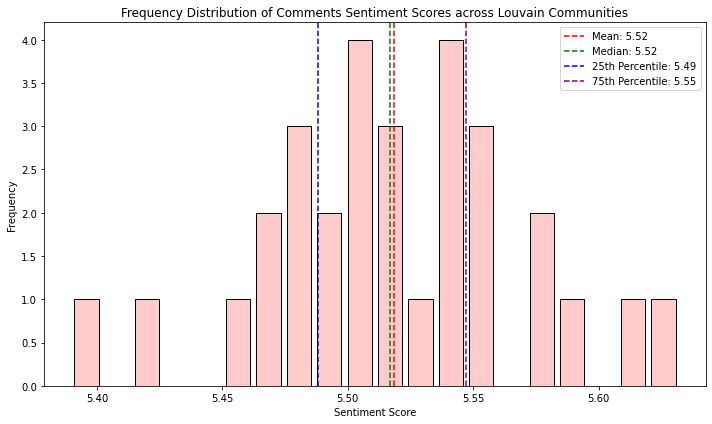

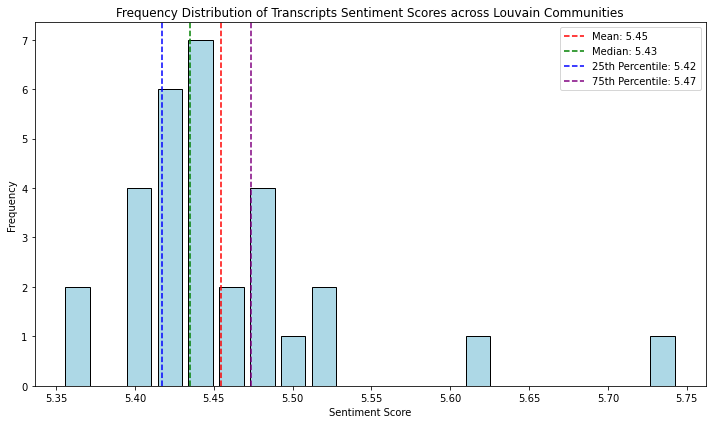

In [63]:
# Function to calculate statistics for sentiments
def calculate_statistics(sentiments):
    return {
        "Mean": np.mean(sentiments),
        "Median": np.median(sentiments),
        "Variance": np.var(sentiments),
        "Min": min(sentiments),
        "Max": max(sentiments),
        "25th Percentile": np.percentile(sentiments, 25),
        "75th Percentile": np.percentile(sentiments, 75)
    }

comments_stats = calculate_statistics(list(community_sentiments_comments.values()))
transcripts_stats = calculate_statistics(list(community_sentiments_transcripts.values()))

# Printing statistics
def print_statistics(title, stats):
    print(f"\n{title}")
    print("-" * len(title))
    for stat_name, stat_value in stats.items():
        print(f"{stat_name}: {stat_value:.2f}")

print_statistics("Comments Sentiment Statistics across Louvain Communities", comments_stats)
print_statistics("Transcripts Sentiment Statistics across Louvain Communities", transcripts_stats)

# Function to plot the frequency distribution with statistics
def plot_sentiment_distribution_with_stats(sentiments, stats, title, color, xlabel='Sentiment Score', ylabel='Frequency'):
    num_bins = 20
    bin_edges = np.linspace(stats["Min"], stats["Max"], num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    frequencies, _ = np.histogram(sentiments, bins=bin_edges)
    
    plt.figure(figsize=(10, 6))
    bar_width = (bin_edges[1] - bin_edges[0]) * 0.8
    plt.bar(bin_centers, frequencies, width=bar_width, color=color, edgecolor='black')
    
    for stat, value in stats.items():
        if stat in ["Mean", "Median", "25th Percentile", "75th Percentile"]:
            color_map = {"Mean": 'red', "Median": 'green', "25th Percentile": 'blue', "75th Percentile": 'purple'}
            plt.axvline(value, color=color_map[stat], linestyle='dashed', linewidth=1.5, label=f'{stat}: {value:.2f}')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plotting the frequency distributions with statistics
plot_sentiment_distribution_with_stats(
    list(community_sentiments_comments.values()),
    comments_stats,
    title='Frequency Distribution of Comments Sentiment Scores across Louvain Communities',
    color='#ffcccb'
)

plot_sentiment_distribution_with_stats(
    list(community_sentiments_transcripts.values()),
    transcripts_stats,
    title='Frequency Distribution of Transcripts Sentiment Scores across Louvain Communities',
    color='#add8e6'
)


**Figure 7: Frequency Distribution of (1) Comment Sentiment Scores and (2) Transcripts Sentiment Scores across Louvain Communities along with their statistics.** The means of comments and transcripts lie at 5.52 and 5.45 respectively and the range is comparable for both.

### Sentiment Analysis for Comments and Transcripts across Categories

In [67]:
# Calculating the average sentiments for categories 
category_avg_sentiments_comments = calculate_average_sentiments(G, sentiment_key='comments_sentiment', attribute_key='categoryId')
category_avg_sentiments_transcripts = calculate_average_sentiments(G, sentiment_key='transcript_sentiment', attribute_key='categoryId')

# Displaying happiest and saddest categories
display_top_groups(
    "Category Sentiment Analysis for Comments",
    category_avg_sentiments_comments,
    mapping=category_mapping,
    group_type="Category"
)

display_top_groups(
    "Category Sentiment Analysis for Transcripts",
    category_avg_sentiments_transcripts,
    mapping=category_mapping,
    group_type="Category"
)



Category Sentiment Analysis for Comments
----------------------------------------

Happiest Groups:
Category Nonprofits & Activism: Average Sentiment = 5.68
Category Music: Average Sentiment = 5.63
Category People & Blogs: Average Sentiment = 5.54

Saddest Groups:
Category Sports: Average Sentiment = 5.44
Category Science & Technology: Average Sentiment = 5.40
Category News & Politics: Average Sentiment = 5.38

Category Sentiment Analysis for Transcripts
-------------------------------------------

Happiest Groups:
Category Nonprofits & Activism: Average Sentiment = 5.52
Category People & Blogs: Average Sentiment = 5.48
Category Entertainment: Average Sentiment = 5.47

Saddest Groups:
Category Science & Technology: Average Sentiment = 5.37
Category News & Politics: Average Sentiment = 5.36
Category Pets & Animals: Average Sentiment = 5.26


The top 3 saddest and happiest video categories according to comments' and transcripts' sentiment scores show a narrow sentiment range. Like the Louvain Communties, the categories also appear to be neutral overall despite the categories belonging to very different themes.


Comments Sentiment Statistics across Categories
-----------------------------------------------
Mean: 5.50
Median: 5.51
Variance: 0.01
Min: 5.38
Max: 5.68
25th Percentile: 5.46
75th Percentile: 5.52

Transcripts Sentiment Statistics across Categories
--------------------------------------------------
Mean: 5.41
Median: 5.43
Variance: 0.00
Min: 5.26
Max: 5.52
25th Percentile: 5.38
75th Percentile: 5.46


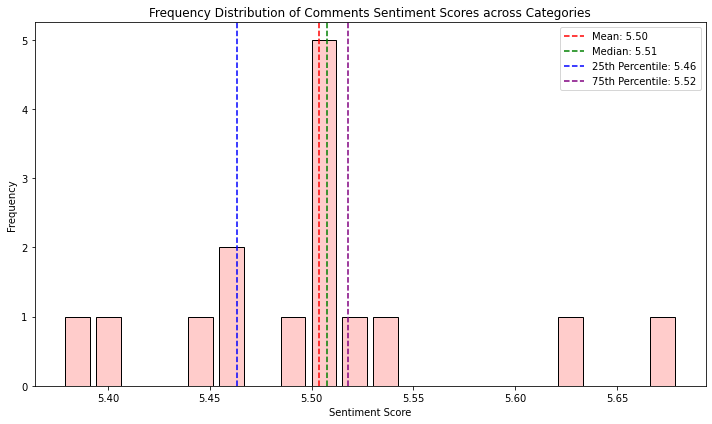

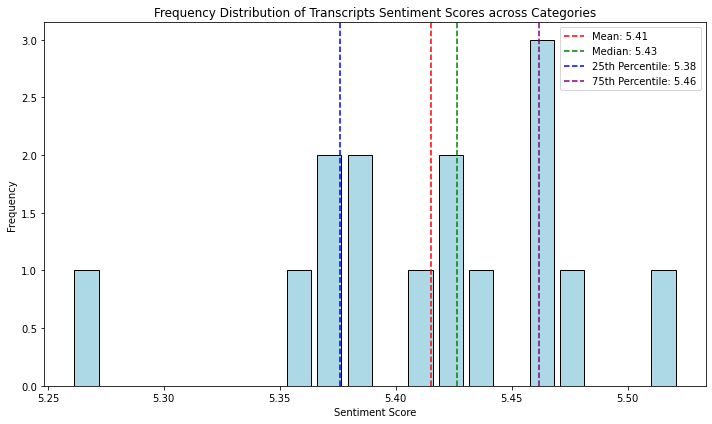

In [68]:
# Calculating statistics for category sentiments
comments_stats_by_category = calculate_statistics(list(category_avg_sentiments_comments.values()))
transcripts_stats_by_category = calculate_statistics(list(category_avg_sentiments_transcripts.values()))
print_statistics("Comments Sentiment Statistics across Categories", comments_stats_by_category)
print_statistics("Transcripts Sentiment Statistics across Categories", transcripts_stats_by_category)

# Plotting frequency distributions for comments and transcripts
plot_sentiment_distribution_with_stats(
    list(category_avg_sentiments_comments.values()),
    comments_stats_by_category,
    title='Frequency Distribution of Comments Sentiment Scores across Categories',
    color='#ffcccb'  
)

plot_sentiment_distribution_with_stats(
    list(category_avg_sentiments_transcripts.values()),
    transcripts_stats_by_category,
    title='Frequency Distribution of Transcripts Sentiment Scores across Categories',
    color='#add8e6'  
)


**Figure 8: Frequency Distribution of (1) Comment Sentiment Scores and (2) Transcripts Sentiment Scores across Categories along with their statistics.** It can be observed that the means of comments and transcripts lie at 5.50 and 5.41 respectively and the range is comparable for both, similar to the Louvain Communities.